# Particles

In [1]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [2]:
# ---------------------------- SIMULATION CHECKING FUNCTIONS ----------------------------
def ls(return_list = False, path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    if return_list:
        return subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip().split('\n')
    else:
        print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    try:
        file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    except:
        print('File not found at: ' + path + folder + f'/Job.{n}/' + file_name)
        return
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix='' , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0, only_sim_obj = True):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    if only_sim_obj:
        file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
        matching_files = glob.glob(file_pattern)
        if matching_files:
            with open(matching_files[0], 'r') as file:
                config = yaml.load(file, Loader=yaml.FullLoader)
                obj_list = config['run']['save_list']

    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP', 'BLM', 'TCLA', 'TFT']:
                if only_sim_obj:
                    if any([file_lines[i-1] in obj for obj in obj_list]):
                        print(file_lines[i-1]+suffix+' = '+file_lines[i])
                else:    
                    print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])



def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
    matching_files = glob.glob(file_pattern)
    if matching_files:
        with open(matching_files[0], 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])


def check_hdf_keys(input_path):
    with pd.HDFStore(input_path, 'r') as store:
         keys = store.keys()
    for key in keys:
        print(key)


def display_rows(rows = None, cols = None):
    pd.set_option('display.max_rows', rows)
    pd.set_option('display.max_columns', cols)


def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def erfunc(x,a,b,c,d):
    return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
    
def normalize_histograms(ax, A, mu, sigma, xmin = 0.009, xmax = 0.015):

    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

     #ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    hist_values = [rect.get_height() for rect in ax.patches]
    bin_edges = [rect.get_x() for rect in ax.patches]
    df = pd.DataFrame({'bin_edges': bin_edges, 'hist_values': hist_values})
    df = df[(df.bin_edges > xmin) & (df.bin_edges < xmax)]
   

    # Calculate the area of the histogram
    bin_widths = np.diff(df.bin_edges)  
    bin_widths = np.append(bin_widths, 0) 
    hist_area = np.sum(df.hist_values * bin_widths)  


    tmp_y = gaussian(x, A, mu, sigma)
    funct_area = np.trapz(tmp_y, x=x)
    new_A = A/funct_area*hist_area
    return new_A, mu, sigma

In [3]:
# ----------------------------- TURN AND COMPARISON FUNCTIONS ----------------------------


def plot_at_turn(TCCS, TARGET, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df_TCCS = TCCS.data
    df_TARGET = TARGET.data #impact_part()
    df_TARGET_all = TARGET.data

    df_TCCS = df_TCCS[df_TCCS['this_turn']==n_turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==n_turn]
    df_TARGET_all = df_TARGET_all[df_TARGET_all['this_turn']==n_turn]

    print("IMPACT ON TCCS AT TURN ", n_turn)
    try:
        ax_TCCS_list = TCCS.plot_distributions(df_TCCS['x'], df_TCCS['y'], df_TCCS['px'], df_TCCS['py'], xpcrit=True, return_fig=True, percentile = percentile, bins = 300)
        if plot_whole:
            ax_TCCS_list[1][1].hist(TCCS.data['y'], bins=100, alpha = 0.3) 
            ax_TCCS_list[1][2].scatter(TCCS.data['x'], TCCS.data['y'], alpha = 0.03, zorder=1) 
            ax_TCCS_list[1][4].hist(TCCS.data['py'], bins=100, alpha = 0.3) 
    except:
        print('No TCCS impacts')
    
    print("IMPACT ON TARGET AT TURN ", n_turn)    
    try:
        ax_TARGET_list = TARGET.plot_distributions(df_TARGET['x'], df_TARGET['y'], df_TARGET['px'], df_TARGET['py'],  return_fig=True, percentile = percentile, bins = 300)
        if plot_whole:
            ax_TARGET_list[2].scatter(TARGET.data['x'], TARGET.data['y'], alpha = 0.03, zorder=1) 
    except:
        print('No TARGET impacts')

    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]

    print('TCCS impacts: ', len(df_TCCS), '\ninside critical angle:', len(channable)  ,'\nTARGET impacts' ,len(df_TARGET), '\nCommon impacts: ', len(common_ids))

    df_common = df_TCCS[df_TCCS['particle_id'].isin(common_ids)]
    print("\nIMPACTS ON TARGET FROM TCCS AT TURN ", n_turn)    
    try:
        ax_common_list = TCCS.plot_distributions(df_common['x'], df_common['y'], df_common['px'], df_common['py'], xpcrit=True, return_fig=True, bins = 300)

        if plot_chann:
            ax_TCCS_list[1][2].scatter(df_common['x'], df_common['y'], color='pink',zorder=10, alpha =0.01) 
            ax_TCCS_list[1][4].hist(df_common['py'], bins=90, alpha = 0.3, color='pink')
    except:
        print('No common impacts')

def check_plot_turns(TCCS, TARGET, turns=200):
    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part()
    tccs, target, channable, common = [], [], [], []
    x = np.arange(turns)
    for t in range(turns):
        tccs.append(len(df_TCCS[df_TCCS['this_turn']==t]))
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))
        tmp_TCCS = df_TCCS[df_TCCS['this_turn']==t]
        tmp_target = df_TARGET[df_TARGET['this_turn']==t]
        common_ids = np.intersect1d(tmp_TCCS['particle_id'], tmp_target['particle_id'])
        channable.append(len(tmp_TCCS[(tmp_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (tmp_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]))
        common.append(len(tmp_TCCS[tmp_TCCS['particle_id'].isin(common_ids)]))

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(x, tccs, label='TCCS impacts')
    ax.plot(x, target, label='TARGET impacts')
    ax.plot(x, channable, label='TCCS impacts inside critical angle')
    ax.plot(x, common, label='Common impacts')
    #ax.set_yscale('log')
    ax.legend()
    print(np.argmax(target))



def plot_turn_impacts(impact_list, turns=200, threshold=10000, labels = None, linestyles = None, return_fig = False):
    if not hasattr(impact_list, '__iter__'):
            impact_list = [impact_list]
    dfs = [i.impact_part() for i in impact_list]

    x = np.arange(turns)
    fig, ax = plt.subplots(figsize=(10, 7))

    for i, df in enumerate(dfs):
        imp = []
        for t in range(turns):
            imp.append(len(df[df['this_turn']==t]))

        if labels is not None:
            label=labels[i]
        else:
             label = f'impacts {i}'
        if linestyles is not None:
            linestyle=linestyles[i]
        else:
            linestyle = '-'
        ax.plot(x, imp, label=label, linewidth=2, linestyle=linestyle, marker='o')
        peaks = []
        for i in range(1, len(imp)):
            if imp[i] - imp[i-1] > threshold:
                peaks.append(i)
        print('\nPeaks at turns: ', peaks)       
        print('Absolute max: ', np.argmax(imp))

    ax.legend()
    ax.set_xlabel('Turn number')
    ax.set_ylabel('N impacts')

    if return_fig:
        return fig, ax  

def calculate_target_impacts_threshold(TARGET, threshold , turns=200):
    df_TARGET = TARGET.impact_part()
    target = []
    x = np.arange(turns)
    for t in range(turns):
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))

    print('thershold: ', threshold, 'before thershold: ', np.sum(target[:threshold]), f"{  (np.sum(target[:threshold])/np.sum(target)*100):.{1}f}% \t after thershold: ", np.sum(target[threshold:]), f"   {(np.sum(target[threshold:])/np.sum(target)*100):.{1}f}%")

##### class

In [4]:
TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'

CRY_name ='tcpch.a5r7.b2'
TCP_name = 'tcp.d6r7.b2'
LIN_name = 'tcsg.b4r7.b2'

class ParticleAnalysis():

    def __init__(self, n_sigma, length, sigma, xdim = None, ydim = None, beam = 2, plane = 'V', jaw_L = None, emittance_n = 3.5e-6):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        if jaw_L is not None:
            self.jaw_L = jaw_L
        else:
            self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.gamma0 = None
        self.beta0 = None
        self.charge = None
        self.mass = None
        self.emittance_n = emittance_n
        self.emittance = None

        if xdim is not None and ydim is not None:
            if self.plane == 'H':
                self.abs_y_low = -self.ydim/2
                self.abs_y_up = self.ydim/2
                self.abs_x_low = self.jaw_L
                self.abs_x_up = self.jaw_L + self.xdim
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = self.jaw_L + self.ydim
                self.abs_x_low = -self.xdim/2
                self.abs_x_up = self.xdim/2
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
        else:
            if self.plane == 'H':
                self.abs_y_low = None
                self.abs_y_up = None
                self.abs_x_low = self.jaw_L
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = None
                self.abs_x_low = None
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.tw = None     
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/", Condor = True, n_return = None):
        
        if Condor:
            test_list = [path + i for i in os.listdir(path) if prefix_name in i]
            for test_name in test_list:

                n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

                path_list =[]

                for i in range(n_jobs):
                    file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                    if os.path.exists(file_path_part):
                        path_list.append(file_path_part)

                n_jobs_verify  = len(path_list)
                if n_jobs != n_jobs_verify:
                    print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        else:
            path_list = (subprocess.check_output("echo " + path + prefix_name +file_name, shell=True)).decode('ascii').strip()
        
        if not hasattr(path_list, '__iter__') or isinstance(path_list, str):
            path_list = [path_list]

        if n_return is not None:
            return path_list[:n_return]
        else:
            return path_list   
    


    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       n_return = None,
                       part_per_job = 50000,
                       **kwargs):

        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return)       
        if Condor == True:
            self.part_per_job = part_per_job
            self.n_jobs = len(h5_file_path)

        df_particles = pd.DataFrame()
        npart = 0
        for file in h5_file_path:

            job_id = int(file.split('Job.')[1].split('/')[0]) if Condor else 0
            
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V                  
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*job_id    
                if 'at_element' in df_tmp.columns and df_tmp['at_element'].dtype == 'int32':
                    try:
                        idx_table = pd.read_hdf(file, key='idx').to_dict()[0]
                        df_tmp['at_element'] = df_tmp['at_element'].map(idx_table)
                    except:
                        pass
            
                for col in ['interactions']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)
                
                for col in ['TCCP_turn', 'TCCS_turn', 'CRY_turn']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)           
                        df_tmp[col] = df_tmp[col].apply(lambda x: [int(i) if i != 'None' else i for i in x] )
                        df_tmp[col] = df_tmp[col].apply(lambda x: [] if 'None' in x else x)                
                
                TCP_turns = []

                if 'TCP_turn' in df_tmp.columns:
                    for s in df_tmp['TCP_turn']:
                        TCP_turns.append(ast.literal_eval(f'[{s}]') if s != "None" else [[],[],[]]) 
                    df_tmp['TCP_turn'] = TCP_turns
                
                df_particles = pd.concat([df_particles, df_tmp])

            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)

                  
        self.npart = npart

        if 'p0c' in df_particles.columns:     
            if len(df_particles['p0c'].unique()) == 1:
                p0c = df_particles['p0c'].unique()[0]
            else:
                print('There are particles at different energies')            
            self.p0c = p0c
        else:
            metadata = pd.read_hdf(h5_file_path[0], key='metadata').to_dict()[0]

            self.p0c = metadata['p0c']
            self.gamma0 = metadata['gamma0']
            self.beta0 = metadata['beta0']
            self.charge = metadata['q0']
            self.mass = metadata['mass0']
            self.emittance = self.emittance_n / (self.gamma0 * self.beta0)


        return df_particles.reset_index(drop=True)
    
    def impact_part(self, eps=9e-10):
        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = self.data['x'] >= self.abs_x_low-eps
            elif self.plane == 'V':
                hit_mask = self.data['y'] >= self.abs_y_low-eps
        else:
            hit_mask = ((self.data['x'] >= self.abs_x_low - eps) & (self.data['x'] <= self.abs_x_up  - eps) & (self.data['y'] >= self.abs_y_low  - eps) & (self.data['y'] <= self.abs_y_up - eps))
        return self.data[hit_mask]   
    
    def get_job_id(self, abs_id, TCCS = None):
        
        if not hasattr(abs_id, '__iter__') or isinstance(abs_id, str):
            abs_id = [abs_id]
        elif isinstance(abs_id, pd.Series):
            abs_id = abs_id.to_list()

        for id in abs_id:
            print(f'\nabs_id: {id}')
            if TCCS is not None:
                df_tccs = TCCS.data
                df_tccs = df_tccs[df_tccs['particle_id'] == id]
                if len(df_tccs==1):
                    print('Part is in TCCS')
                    if df_tccs.py.iloc[0] > TCCS.align_angle - np.abs(TCCS.xp_crit) and df_tccs.py.iloc[0] < TCCS.align_angle + np.abs(TCCS.xp_crit):
                        print('Part in critical angle')
                    else:   
                        print('Part is NOT in critical angle')
                else:
                    print('Particle is NOT in TCCS')
               
                
            number = id/self.part_per_job
            integer_part = int(divmod(number, 1)[0])

            fractional_part = int(np.round((number % 1) * self.part_per_job))

            print('Turn of channeling: ', self.data[self.data['particle_id'] == id].this_turn.iloc[0])
            print(f"Job Number: {integer_part}, ID: {fractional_part} ")

    def hist_jobs(self):   
        jobs = divmod(self.data['particle_id']/self.part_per_job, 1)[0]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(jobs, bins=self.n_jobs)
        ax.set_xlabel('job_id')
        ax.set_ylabel('n_part')    

    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r', facecolor='none', alpha=1):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor=facecolor, alpha = alpha, zorder=zorder, linewidth=linewidth)
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y, bins = 100, axins_params = ["100%", "5%", "right", -6], sigma_line = True, vmin =None, vmax = None, print_vmax= False, **kwargs):
       
        log_norm = matplotlib.colors.LogNorm(vmin=vmin, vmax= vmax)
        h = ax.hist2d(x, y, bins=bins, norm=log_norm, zorder=2)
        if print_vmax:
            log_norm.autoscale(h[0])
            print('vmax: ', log_norm.vmax)
    
        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])
        if 'plot_support' in kwargs.keys() and kwargs['plot_support'] == True:
            ax.set_xlim(-12.5e-3, 12.5e-3)
            ax.set_ylim(self.abs_y_low-4e-3, self.abs_y_up+11e-3)
    

        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_xticks()])
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_yticks()])
        

        if self.plane == 'V':

            ax_tw = ax.twinx()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_ylim((ax.get_ylim()[0]-self.ref)/sigma_abs, (ax.get_ylim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
            ax_tw.set_yticks(yticks)
            ax_tw.set_ylabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
            #go_support
            if 'plot_support' in kwargs.keys() and kwargs['plot_support'] == True:
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up+8e-3, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'blue', facecolor ='lightblue', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'blue', facecolor ='lightblue', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up + 8e-3, self.abs_y_low, self.abs_y_low-1e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_low, self.abs_y_low-1e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_up + 1.1e-3, self.abs_x_up + 8e-3, self.abs_y_low-1e-3, self.abs_y_low-3e-3, zorder = 1, linewidth = 2, edgecolor = 'grey',  facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low-1.1e-3, self.abs_y_low-1e-3, self.abs_y_low-3e-3, zorder = 1, linewidth = 2, edgecolor = 'grey',    facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up + 8e-3, self.abs_y_up, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_up, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_up+5e-3, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey', facecolor ='lightgrey', alpha=0.5)
                self.plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'r')
                
                
        elif self.plane == 'H':

            ax_tw = ax.twiny()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_xlim((ax.get_xlim()[0]-self.ref)/sigma_abs, (ax.get_xlim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 20 and ax_tw.get_xlim()[0] - ax_tw.get_xlim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 60 and ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_xlim()[0]), np.floor(ax_tw.get_xlim()[1]) + 1, n_ticks)
            ax_tw.set_xticks(yticks)
            ax_tw.set_xlabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axvline(self.n_sigma, color = 'r', linestyle = '--')

        axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')

        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
            ax_tw.set_ylim((kwargs['ylim'][0]-self.ref)/sigma_abs, (kwargs['ylim'][1]-self.ref)/sigma_abs)
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])

            


    def plot_ang_distribution(self, fig, ax, py, bins = 100, fit = None, **kwargs):
        ax.hist(py, bins=bins) 
        if self.plane == 'V':
            ax.set_xlabel(r'py [$\mu$rad]')
        elif self.plane == 'H':
            ax.set_xlabel(r'px [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax.get_xticks()])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions_base(self, x, y, px, py, 
                                bins_x = 100, bins_y = 100, bins_px= 100, bins_py = 100,
                                vmin =None, vmax = None, 
                                fit = None, return_fig = False, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']

        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = x >= self.abs_x_low
            elif self.plane == 'V':
                hit_mask = y >= self.abs_y_low
        else:
            hit_mask = ((x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y<= self.abs_y_up))
        
        hitting_particles = sum(hit_mask)

        if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            pym = (py >= py_min) & (py <= py_max)
        
            px_min = np.percentile(px,kwargs['percentile'])
            px_max = np.percentile(px,100-kwargs['percentile'])
            pxm = (px >= px_min) & (px <= px_max)

            y_min = np.percentile(y,kwargs['percentile'])
            y_max = np.percentile(y,100-kwargs['percentile'])
            ym = (y >= y_min) & (y <= y_max)
         
            x_min = np.percentile(x,kwargs['percentile'])
            x_max = np.percentile(x,100-kwargs['percentile'])
            xm = (x >= x_min) & (x <= x_max)

        else:
            pym = np.ones(len(py), dtype=bool)
            pxm = np.ones(len(px), dtype=bool)
            ym = np.ones(len(y), dtype=bool)
            xm = np.ones(len(x), dtype=bool)
            
        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x[xm & ym], bins=bins_x)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        if lines:
            ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
            ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=ax1.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax1.get_xticks()])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y[xm & ym], bins=bins_y) 
        ax2.set_xlabel('y [mm]')
        if lines:
            ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
            ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=ax2.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax2.get_xticks()])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)

        ax12 = fig1.add_subplot(2,3,4)
        ax22 = fig1.add_subplot(2,3,5)

        if self.plane == 'V':
        
            ax12.hist(px[pxm & pym & hit_mask], bins=bins_px)
            ax12.set_xlabel(r'px [$\mu$rad]')
            ax12.set_ylabel("")        
            ax12.set_xticks(ticks=ax12.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax12.get_xticks()])
      
            self.plot_ang_distribution(fig1, ax22, py[pym & pxm & hit_mask], bins = bins_py, **kwargs)

        elif self.plane == 'H':

            self.plot_ang_distribution(fig1, ax12, px[pym & pxm & hit_mask], bins = bins_px, **kwargs)
            
            ax22.hist(py[pxm & pym & hit_mask], bins=bins_py)
            ax22.set_xlabel(r'py [$\mu$rad]')
            ax22.set_ylabel("")        
            ax22.set_xticks(ticks=ax22.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax22.get_xticks()])
      
   


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px[hit_mask], py[hit_mask], bins=(bins_px, bins_py), norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), zorder=2)  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=ax32.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_xticks()])
        ax32.set_yticks(ticks=ax32.get_yticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_yticks()])
        if len(px[hit_mask]) > 0:
            axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
            fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        if return_fig:
            return fig1, [ax1, ax2, ax3, ax12, ax22, ax32]  
        else:
            plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss


    # BBBBBB
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, return_fig = False, bins = 200, vmin=None, vmax = None,  **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit
        if return_fig:
            return self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], return_fig = return_fig ,  sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, bins = bins, vmin =vmin, vmax = vmax, **kwargs)
        else:
            self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, bins = bins, vmin = vmin, vmax = vmax, **kwargs)

    def plot_phasespace(self, impacts = False, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        if impacts:
            px, py, x, y = self.impact_part()['px'], self.impact_part()['py'], self.impact_part()['x'], self.impact_part()['y']
        else:
            px, py, x, y  = self.data['px'], self.data['py'], self.data['x'], self.data['y']
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(x, px, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(y,py, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')

        if self.plane == 'V':
            ax2.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax2.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax2.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax2.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')
        elif self.plane == 'H':
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax1.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax1.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax1.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')

        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, show_zoom = zoom,  outfile = outfile)

    def plot_lossmap(self, zoom = None, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", outfile = None):

        if zoom == 'IR7':
            lm.plot_lossmap(self.lossmap, show_zoom = True,   outfile = outfile)
        elif zoom == 'IR3':
            lm.plot_lossmap(self.lossmap, zoom_range = [6000,7200],  outfile = outfile)
        else:
            lm.plot_lossmap(self.lossmap, show_zoom = False,   outfile = outfile)
            
    def compute_losses(self, path=None, ):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        names = ['tcp.d6r7.b2', 'tcp.c6r7.b2', 'tcp.b6r7.b2', 'tcla.a5l3.b2',  'tccp.4l3.b2', 'tccs.5r3.b2']
        df_losses = pd.concat([df.query('name in @names'),df[df.losses_N > np.mean(df.losses_N)]]).drop_duplicates(keep='first', subset=df.columns)
        self.losses = pd.merge(df_losses, self.lossmap.inefficiency()[['losses', 's']], on = 's').drop('losses_dE', axis = 1).sort_values(by='s', ascending=True)
        return self.losses

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')

    def count_interactions(self):
        if 'interactions' in self.data.columns:
            data = self.data['interactions'].apply(lambda x: str(x))
            data = data.groupby(data).count().sort_values(ascending=False)
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            print(data)
            if 'nan' in data.index:
                data = data.drop('nan')
            pd.set_option('display.max_rows', 30)
            pd.set_option('display.max_columns', 30)
            print(f"\n ---- Total interacting particles: {data.sum()} ---- \n")
        else:
            print('No interaction data available')


    def twiss_TWOCRYST(self, config_file = None, line_file= None, return_twiss = False, **kwargs):

        print('Computing twiss parameters for TWOCRYST')

        TCCS_name = 'tccs.5r3.b2'
        TCCP_name = 'tccp.4l3.b2'
        TARGET_name = 'target.4l3.b2'
        PIXEL_name = 'pixel.detector'
        TFT_name = 'tft.detector'
        TCP_name = 'tcp.d6r7.b2'
        TCLA_name = 'tcla.a5l3.b2'

        names_list = [TCCS_name, TCCP_name, TARGET_name, PIXEL_name+"_1", TFT_name, TCP_name, TCLA_name]


        if config_file is not None: 
            with open(config_file, 'r') as stream:
                config_dict = yaml.safe_load(stream)   
            line_file = os.path.expandvars(config_dict['input_files']['line_b2'])
        line = xt.Line.from_json(line_file)

        part_energy = None if config_dict['run']['energy'] == 'None' else float(config_dict['run']['energy'])
        if part_energy is not None:
            line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                    q0=1, mass0=xt.PROTON_MASS_EV)

        end_s = line.get_length()

        TCCS_loc_abs  = 6773.9428 
        TCCP_loc_abs  = 6653.2543  
        PIX1_loc_abs = 6652.7039
        PIX2_loc_abs = 6652.6929
        PIX3_loc_abs = 6652.6819
        TFT_loc_abs = 6652.114

        TCCS_loc = end_s - TCCS_loc_abs
        TCCP_loc = end_s - TCCP_loc_abs
        TARGET_loc = end_s - (TCCP_loc_abs + 0.070/2 +  0.005/2)
        PIX1_loc = end_s - PIX1_loc_abs
        PIX2_loc = end_s - PIX2_loc_abs
        PIX3_loc = end_s - PIX3_loc_abs
        TFT_loc = end_s - TFT_loc_abs
        TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
        TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


        line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
        line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
        line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
        line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
        line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
        line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
        line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
        line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
        line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
        line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
        line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
        line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
        line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)

        line.build_tracker()
        line.collimators.assign_optics()
        tw = line.twiss().to_pandas()[['name','s', 'x', 'y', 'betx', 'bety', 'alfx', 'alfy', 'mux', 'muy', ]]
        tw = tw[tw['name'].isin(names_list)]
        tw['s1'] = end_s - tw['s'] 
        tw['sigma_x'] = np.sqrt(self.emittance * tw['betx'])
        tw['sigma_y'] = np.sqrt(self.emittance * tw['bety'])
        display(tw)


        self.tw = tw

        return tw if return_twiss else None
    
    def twiss_MD(self, MD=1000, config_file = None, line_file= None, return_twiss = False, **kwargs):

        print('Computing twiss parameters for MD')

        if config_file is not None: 
            with open(config_file, 'r') as stream:
                config_dict = yaml.safe_load(stream)   
            line_file = os.path.expandvars(config_dict['input_files']['line_b2'])
        line = xt.Line.from_json(line_file)
        run_dict = config_dict['run']
        energy = f'{MD}' #f'{run_dict["energy"]}'
        sim_dict = os.path.expandvars(config_dict['input_files']['sim_dict'])
        with open(sim_dict, 'r') as f:
            data = json.load(f)

        part_energy = data[energy]['energy'] 
        line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
        end_s = line.get_length()
        CRY_name ='tcpch.a5r7.b2'
        LIN_name = 'tcsg.b4r7.b2'
        names_list = [CRY_name, TCP_name, LIN_name]
        line.build_tracker()
        line.collimators.assign_optics()
        tw = line.twiss().to_pandas()[['name','s', 'x', 'y', 'betx', 'bety', 'alfx', 'alfy', 'mux', 'muy', ]]
        tw = tw[tw['name'].isin(names_list)]
        tw['s1'] = end_s - tw['s'] 
        tw['sigma_x'] = np.sqrt(self.emittance * tw['betx'])
        tw['sigma_y'] = np.sqrt(self.emittance * tw['bety'])
        self.tw = tw
        display(self.tw )        

        return tw if return_twiss else None


# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, jaw_L = None,  bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2, #eV/m Silicon    #dp_Si = 1.92e-10 #m
                eta = 0.9,
                xp_version = 'code',
                miscut = 0.0, **kwargs
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma, jaw_L = jaw_L)

    self.miscut = miscut
    self.align_angle = align_angle + self.miscut
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 
    self.eta = eta
    self.xp_version = xp_version
    self.n_CRY_absorbed = None
    self.n_TCCS_absorbed = None
    self.n_TCCP_absorbed = None
    self.TCCS_sim_chann_eff = None
    self.TCCP_sim_chann_eff = None
    self.CRY_sim_chann_eff = None


  def load_particles(self, path, df_key = None, Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000,
                      get_absorbed = 'all'): #all, only, not

    if get_absorbed in ['all', 'not']:
        if df_key is not None:
            self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)
            if 'TCP_turn' in self.data.columns:   
                self.data = self.data[ ['particle_id', 'x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'interactions', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
            
    if get_absorbed in ['all', 'only']:
        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return) 
        n_absorbed_CRY  = 0
        n_absorbed_TCCS = 0
        n_absorbed_TCCP = 0
        TCCS_sim_chann_eff = 0
        TCCP_sim_chann_eff = 0
        CRY_sim_chann_eff = 0
        for file in h5_file_path:
            try:
                metadata = pd.read_hdf(file, key='metadata').to_dict()[0]
                if 'CRY_absorbed' in metadata.keys():
                    n_absorbed_CRY = n_absorbed_CRY + metadata['CRY_absorbed']
                if 'TCCS_absorbed' in metadata.keys():
                    n_absorbed_TCCS = n_absorbed_TCCS + metadata['TCCS_absorbed']
                if 'TCCP_absorbed' in metadata.keys():
                    n_absorbed_TCCP = n_absorbed_TCCP  + metadata['TCCP_absorbed']
                if 'TCCS_sim_chann_eff' in metadata.keys():
                    TCCS_sim_chann_eff = TCCS_sim_chann_eff + metadata['TCCS_sim_chann_eff']
                if 'TCCP_sim_chann_eff' in metadata.keys():
                    TCCP_sim_chann_eff = TCCP_sim_chann_eff + metadata['TCCP_sim_chann_eff']
                if 'CRY_sim_chann_eff' in metadata.keys():
                    CRY_sim_chann_eff = CRY_sim_chann_eff + metadata['CRY_sim_chann_eff']
            except:
                print(f"Error reading metadata from {file}")

        if df_key is None:
            self.part_per_job = part_per_job
            self.n_jobs = len(h5_file_path)
        
        self.n_CRY_absorbed = int(n_absorbed_CRY) if 'CRY_absorbed' in metadata.keys() else None 
        self.n_TCCS_absorbed = int(n_absorbed_TCCS) if 'TCCS_absorbed' in metadata.keys() else None
        self.n_TCCP_absorbed = int(n_absorbed_TCCP) if 'TCCP_absorbed' in metadata.keys() else None
        self.p0c = metadata['p0c']
        self.TCCS_sim_chann_eff = TCCS_sim_chann_eff/self.n_jobs if self.n_jobs is not None else TCCS_sim_chann_eff
        self.TCCP_sim_chann_eff = TCCP_sim_chann_eff/self.n_jobs if self.n_jobs is not None else TCCP_sim_chann_eff
        self.CRY_sim_chann_eff = CRY_sim_chann_eff/self.n_jobs if self.n_jobs is not None else CRY_sim_chann_eff

    if self.xp_version == 'book': 
        xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
        Rcrit = self.p0c/self.en_crit
        self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)

    elif self.xp_version == 'manual':
        dp = 1.92e-10 
        aTF = 0.194e-10
        uT = 0.075e-10
        xc = dp/2 -0.6565*uT
        eta = (xc*2/dp)**2
        Rcrit = self.p0c/(2*eta*self.pot_crit) * xc
        self.xp_crit = np.sqrt(2*eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)

    elif self.xp_version == 'code':
        dp = 1.92e-10 
        Rcrit = self.p0c/(2*np.sqrt(self.eta)*self.pot_crit) * (dp/2)
        self.xp_crit = np.sqrt(2*self.eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)
    
    
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")


    

  def plot_ang_distribution(self, fig, ax, py, print_label=True, **kwargs):

        
        super().plot_ang_distribution(fig, ax, py, **kwargs)


        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print_label:
                        ax.set_title(f'N particle inside critical angle range: {chann}')



  
  def plot_distributions(self, x, y, px, py, bins = 100, fit = None, return_fig = False,vmin =None, vmax = None,  **kwargs):


        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']
        
        # ax_list = [ax1, ax2, ax3, ax12, ax22, ax32]
        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, bin_x=bins, bins_y = bins, bins_px=bins, bins_py=bins, return_fig = True, **kwargs)

        super().plot_xy_distribution(fig, ax_list[2], x, y, bins = bins,  vmin=vmin, vmax=vmax, **kwargs) #xlim = [-12.5e-3, 12.5e-3],

        if lines:
            self.plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        
        if return_fig:
            return fig, ax_list
        elif 'return_xy'in kwargs and kwargs['return_xy']:
            return ax_list[2]
        else:
            plt.show()


  def inside_xp_crit(self, half = False):
    impacts = self.impact_part()
    f = 0.5 if half else 1
    dim = 'py' if self.plane == 'V' else 'px'
    return impacts[(impacts[dim] > self.align_angle - f*np.abs(self.xp_crit)) & (impacts[dim] < self.align_angle  + f*np.abs(self.xp_crit))]

  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', len(self.impact_part()), f'\t{chann_num/len(self.impact_part())*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self, plot = True, return_fig = False):

    if self.plane == 'V':
        p = 'py'
    elif self.plane == 'H':
        p = 'px'
    hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
    data = self.data[[p]][hit_mask]
    min_p = data[p].min()
    max_p = data[p].max()
    
    n_steps = 1000
    x = np.linspace(min_p + self.xp_crit, max_p - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data[p] > x[i] - self.xp_crit) & (data[p] < x[i] + self.xp_crit)
        y.append(len(data[p][mask]))

    best_angle = x[y.index(max(y))]

    if plot:
        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'g', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        self.plot_ang_distribution(fig1, ax2, data[p], xpcrit=True, align_angle = best_angle, print=False)

        chann_mask = (data[p] > self.align_angle  - np.abs(self.xp_crit)) & (data[p] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data[p][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        if return_fig:
            return fig1, [ax1, ax2] 

    print(f'Delta angle {best_angle - self.align_angle}')



  def align_TCCS(self):

        best_jawL = min( self.data['y'])

        new_sigma = best_jawL/self.jaw_L*self.n_sigma
        self.abs_y_low = best_jawL
        self.abs_y_up = best_jawL + self.ydim
        self.n_sigma = new_sigma
        self.jaw_L = best_jawL
        #
        # hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        #self.impact_part = self.data[hit_mask]


  def channeling_efficiency_sim(self, half = False):
        if 'interactions' in self.data.columns:
            in_xp_crit = self.inside_xp_crit(half)
            eff_sim = len(in_xp_crit[in_xp_crit.interactions.apply(lambda x: x == ['CH'])]) / len(in_xp_crit)
            print(f'Channeling efficiency: {eff_sim:.3f}')
        else:
            print('No interaction data available --  get through TCCS_sim_chann_eff and TCCP_sim_chann_eff')



# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, target_type, n_sigma,  sigma, xdim = None, ydim = None, length = None, beam = 2, plane = 'V', jaw_L = None, PIX_y_distance_to_RPX = 4.26e-3, RPX_bottom_wall_thickess = 2.14e-3):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane, jaw_L = jaw_L)
    
    if target_type not in ['pixel', 'alfa', 'target', 'collimator']:
        print('Target type not valid\nAllowed types: [pixel, alfa, target, collimator]')
    self.type = target_type

    self.PIX_y_distance_to_RPX = PIX_y_distance_to_RPX
    self.RPX_bottom_wall_thickess = RPX_bottom_wall_thickess

    if self.type == 'pixel' and self.PIX_y_distance_to_RPX is not None:
        self.abs_y_up = self.abs_y_up + self.PIX_y_distance_to_RPX
        self.abs_y_low = self.abs_y_low + self.PIX_y_distance_to_RPX

    if self.type == 'alfa' and self.RPX_bottom_wall_thickess is not None:
        self.abs_y_up = self.abs_y_up + self.RPX_bottom_wall_thickess
        self.abs_y_low = self.abs_y_low + self.RPX_bottom_wall_thickess

    self.LSdata = None
    self.erf_params = None

  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000):
        
    self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)  
    if 'TCP_turn' in self.data.columns:
        self.data = self.data[ ['particle_id','x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
    
           

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids!') #: {data[duplicated_mask]}')


  def get_pentagonal(self, y_lim = None):

    y_lim = self.jaw_L if y_lim is None else y_lim
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return ALFA_x, ALFA_y

  def get_intersections(self, ALFA_x, ALFA_y, y_horizontal = None):

    y_horizontal = self.jaw_L + self.RPX_bottom_wall_thickess if y_horizontal is None else y_horizontal

    pentagon = []
    for i, j in zip(ALFA_x, ALFA_y):
        pentagon.append([i, j])

    intersections = []
   
    # Function to find the intersection between a horizontal line and a line segment
    def find_intersection(p1, p2, y_horizontal):
        x1, y1 = p1
        x2, y2 = p2
        
        # Check if the line segment intersects the horizontal line
        if (y1 - y_horizontal) * (y2 - y_horizontal) <= 0:
            # Calculate the intersection point
            if y1 != y2:
                x_intersect = x1 + (x2 - x1) * (y_horizontal - y1) / (y2 - y1)
                return (x_intersect, y_horizontal)
        return None

    for i in range(len(pentagon)):
        p1 = pentagon[i]
        p2 = pentagon[(i + 1) % len(pentagon)]
        intersection = find_intersection(p1, p2, y_horizontal)
        if intersection:
            intersections.append(intersection)

    return intersections



  # AAAAAA
  def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, return_xy = False,  plot_support = False, bins = 200, vmin =None, vmax = None, **kwargs):

        lines = True if 'lines' not in kwargs else kwargs['lines']
        lines = False if self.type == 'collimator' else lines 

        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, return_fig = True, lines = lines, bins_x=bins, bins_y = bins, bins_px=bins, bins_py=bins, **kwargs)

        if self.type == 'alfa':
           
            ALFA_x, ALFA_y = self.get_pentagonal(y_lim = self.jaw_L + 500e-6)

            super().plot_xy_distribution(fig, ax_list[2], x, y,  xlim = [np.min(ALFA_x)-1e-3, np.max(ALFA_x)+1e-3], ylim = [self.jaw_L-3.5e-3, np.max(ALFA_y)+1e-3], bins = (round(self.xdim /30e-6), round(self.ydim /30e-6)), vmin=vmin, vmax = vmax, **kwargs)
            
            if lines:
                ax_list[1].axvline(self.jaw_L, color = 'grey', linestyle = '-')
                ax_list[1].axvline(self.jaw_L + self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
                ax_list[2].plot(ALFA_x, ALFA_y, 'r')
                #super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.jaw_L, self.jaw_L + self.RPX_bottom_wall_thickess)
                #ax_list[2].axhline(self.jaw_L, color = 'grey', linestyle = '-')
                #
        
        elif self.type == 'pixel':

            if plot_support:
                ALFA_x, ALFA_y = self.get_pentagonal(y_lim = self.jaw_L + 200e-6)
                xlim = [np.min(ALFA_x)-1e-3, np.max(ALFA_x)+1e-3]
                ylim = [self.jaw_L-3.5e-3, np.max(ALFA_y)+1e-3]
            else:
                xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3]
                ylim = [self.jaw_L-3.5e-3, self.abs_y_up+1e-3]

            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim=xlim, ylim = ylim,  bins = (round(self.xdim /55e-6), round(self.ydim /55e-6)),vmin=vmin, vmax=vmax, **kwargs)            

            if lines:
                if self.xdim/self.ydim == 3:
                    super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_low + self.xdim/3, self.abs_y_low, self.abs_y_up)
                    super().plot_rectangle(ax_list[2], self.abs_x_low + self.xdim/3, self.abs_x_low + self.xdim/3*2, self.abs_y_low, self.abs_y_up)
                    super().plot_rectangle(ax_list[2], self.abs_x_low + self.xdim/3*2, self.abs_x_up, self.abs_y_low, self.abs_y_up)
                else:
                    super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
                #super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.jaw_L, self.jaw_L + self.RPX_bottom_wall_thickess)
                #ax_list[2].axhline(self.jaw_L, color = 'grey', linestyle = '-')
                #ax_list[2].axhline(self.jaw_L + self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
                ax_list[1].axvline(self.jaw_L, color = 'grey', linestyle = '-')
                ax_list[1].axvline(self.jaw_L + self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
        
        elif self.type == 'target':
            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3], lines = lines, bins = bins, vmin = vmin, vmax = vmax,  **kwargs) 
            if lines:
                super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        elif self.type == 'collimator':
            super().plot_xy_distribution(fig, ax_list[2], x, y, lines = lines, bins = bins, vmin = vmin, vmax= vmax, **kwargs) 
            if self.plane == 'V':
                ax_list[1].axvline(self.jaw_L, color = 'r', linestyle = '-')
            elif self.plane == 'H':
                ax_list[0].axvline(self.jaw_L, color = 'r', linestyle = '-')

        
        if plot_support:
            ALFA_x, ALFA_y = self.get_pentagonal(y_lim = self.jaw_L + 200e-6)
            xlim = [np.min(ALFA_x)-1e-3, np.max(ALFA_x)+1e-3]
            intersections = self.get_intersections(ALFA_x, ALFA_y)
            ax_list[2].plot(ALFA_x, ALFA_y, 'grey', linewidth = 2)
            ax_list[2].axhline(self.jaw_L, color='grey', linestyle='-', zorder= 10)
            ax_list[2].plot([xlim[0], intersections[1][0]], [self.jaw_L + self.RPX_bottom_wall_thickess, self.jaw_L + self.RPX_bottom_wall_thickess], color='grey', linestyle='-', zorder= 10)
            ax_list[2].plot([intersections[0][0], xlim[1]], [self.jaw_L + self.RPX_bottom_wall_thickess, self.jaw_L + self.RPX_bottom_wall_thickess], color='grey', linestyle='-', zorder= 10)

        return fig, ax_list if return_fig else fig, ax_list[2] if return_xy else plt.show()


  def optimize_POT(self, set = False, mode='fit', plot = True, vmin =None, vmax = None, **kwargs):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        if plot:
            fig1 = plt.figure(figsize=(16, 5))
            ax1 = fig1.add_subplot(1,2,1)
            ax1.plot(steps, n_part)
            ax1.set_xlabel('y position [mm]')
            ax1.set_ylabel("n_part")
            ax1.axvline(best_jawL, color = 'g', linestyle = '-')
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

            ax3 = fig1.add_subplot(1,2,2)
            super().plot_xy_distribution(fig1, ax3, x, y, vmin = vmin, vmax = vmax, **kwargs)
            super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

            hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

            fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            #self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part()) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')


  def get_twiss_for_linear_scan(self, CRY_name =  TCCS_name, COLL_name = TCLA_name, config_file = None, line_file= None, tw = None, MD=None):

    if self.tw is None and tw is None:
        if MD is not None:
            self.twiss_MD(MD, config_file = config_file, line_file = line_file)
        else:
            self.twiss_TWOCRYST(config_file = config_file, line_file = line_file)
    elif self.tw is None and tw is not None:
        self.tw = tw

    if COLL_name == PIXEL_name:
        COLL_name = PIXEL_name + '_1'

    if self.plane == 'V':
        mu = 'muy'
        beta = 'bety'
        alfa = 'alfy'
        dim = 'y'
    elif self.plane == 'H':
        mu = 'mux'
        beta = 'betx'
        alfa = 'alfx'
        dim = 'x'

    deltaphi = float(self.tw[self.tw.name == COLL_name][mu])% 1* 2*np.pi - float(self.tw[self.tw.name == CRY_name][mu])% 1* 2*np.pi
    beta_CRY = self.tw[self.tw.name == CRY_name][beta].iloc[0]
    beta_COLL = self.tw[self.tw.name == COLL_name][beta].iloc[0]
    alpha_CRY = self.tw[self.tw.name == CRY_name][alfa].iloc[0]
    alpha_COLL = self.tw[self.tw.name == COLL_name][alfa].iloc[0]
    CO_CRY = self.tw[self.tw.name == CRY_name][dim].iloc[0]
    CO_TCP = self.tw[self.tw.name == TCP_name][dim].iloc[0]
    beta_TCP = self.tw[self.tw.name == TCP_name][beta].iloc[0]
        
    return beta_CRY, beta_COLL, deltaphi


  def linear_scan(self, PosMaxErfFit = 6.2e-3, PosEnvelope = None, LSdata = None,
					beta_CRY =  None, beta_COLL = None, deltaphi_CRY_COLL = None, 
					param0 = [0.5, -1, 7e-3, 0.0002], step = 1e-4, return_fig = False, save_data = False, **kwargs):
    
    if beta_CRY is None:
        beta_CRY, beta_COLL, deltaphi_CRY_COLL = self.get_twiss_for_linear_scan(**kwargs)

    self.LSdata = LSdata if LSdata is not None else self.LSdata

    dim = "y" if self.plane == 'V' else "x"

    if self.LSdata is None:
        max_y = round(self.data[dim].max(), 5)
        min_y = round(self.data[dim].min(), 5)
        CollPos =  np.linspace(min_y, max_y, int((max_y - min_y) / step))[::-1]
        counts = np.zeros(len(CollPos))
        for pos in CollPos:
            counts[np.where(CollPos == pos)] = len(self.data[self.data[dim] >= pos])
        self.LSdata = pd.DataFrame({'CollPos': CollPos, 'Counts': counts})
        
    if PosEnvelope is None:
        PosEnvelope = self.jaw_L

    normalize = self.LSdata.Counts[np.where(self.LSdata.CollPos==min(self.LSdata.CollPos, key=lambda x: abs(x - PosEnvelope)))[0][0]] 
    self.LSdata.Counts = self.LSdata.Counts / normalize

    def erfunc(x,a,b,c,d):
        return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

    params, extras = opt.curve_fit(erfunc, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].CollPos, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].Counts, p0=param0)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(self.LSdata.CollPos, self.LSdata.Counts)
    #ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, param0[0], param0[1], param0[2], param0[3]))
    ax.plot(self.LSdata.CollPos, erfunc(self.LSdata.CollPos, params[0], params[1], params[2], params[3]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
    ax.axvline(PosMaxErfFit, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    ax.axhline(1, color='b', linestyle='--')


    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')


    # distance between centre of channeled beam and primary beam envelope
    deltax = (abs(params[2])-abs(PosEnvelope))

    theta_calc = (deltax-self.n_sigma*np.sqrt(self.emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))

    x1 = -abs(PosEnvelope)
    y1 = 0
    x2 = -abs(params[2])
    y2 = theta_calc*1.0e6
    m = (y2-y1)/(x2-x1)
    q = y1-m*x1

    self.LSdata['CollPos_thetaframe']= -m*self.LSdata['CollPos']+q

    ax2 = ax.twiny()
    ax2.plot(self.LSdata.CollPos_thetaframe, self.LSdata.Counts, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)
    ax.set_ylim(0,1.4)
    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    #ax.plot(self.LSdata.CollPos, 0.0001*abs(params[1])*norm.pdf(self.LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')

    efficiency = round(abs(params[1])*100,2)
    print('Efficiency: ', efficiency, '%')
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    self.erf_params = params
    if save_data:
        Fitmetadata = pd.DataFrame({'param0': params[0],
                                'param1': params[1],
                                'param2': params[2],
                                'param3': params[3],
                                'PosMaxErfFit': PosMaxErfFit,
                                'PosEnvelope': PosEnvelope,
                                'normal': normalize,
                                'theta_calc': theta_calc,
                                'deltax': deltax,
                                'beta_CRY':beta_CRY, 
                                'beta_COLL': beta_COLL,
                                'deltaphi_CRY_COLL': deltaphi_CRY_COLL
                                }, index=[0])
        Fitmetadata.to_hdf(f'./Data/MD_LS_sim{kwargs["MD"]}.h5', key='metadata', format='table', mode='a', complevel=9, complib='blosc')
        self.LSdata.to_hdf(f'./Data/MD_LS_sim{kwargs["MD"]}.h5', key='LSdata', format='table', mode='a', complevel=9, complib='blosc')

    return fig, ax, ax2 if return_fig else None


      

In [5]:
def plot_at_turn_simple(OBJ, n_turn, percentile = 0.0):

    df = OBJ.data
    df = df[df['this_turn']==n_turn]
    print("IMPACT ON TCCS AT TURN ", n_turn)    
    ax_list = OBJ.plot_distributions(df['x'], df['y'], df['px'], df['py'],  return_fig=True, percentile = percentile)


# Local

In [136]:
CRY_loc = CrystalAnalysis(plane='H', n_sigma=6.110539, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0144112698, miscut = -0.014324,sigma=0.0008148661018450332, jaw_L=0.00497979123700652)
LIN_SCAN_loc = TargetAnalysis(plane='H', n_sigma=6.110539, target_type='collimator', length=1,sigma=0.0007101460983541389, jaw_L=0.00433993122599885)

In [137]:
#CRY_loc = CrystalAnalysis(plane='H', n_sigma=6.03665, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0144525418, miscut = -0.014324,sigma=0.001214925952193352, jaw_L=0.007334604717154749)
#LIN_SCAN_loc = TargetAnalysis(plane='H', n_sigma=6.03665, target_type='collimator', length=1,sigma=0.0010587937506844319, jaw_L=0.006392125577205032)

In [138]:
CRY_loc.load_particles('', file_name='particles_B2H.h5', Condor = False,
                      default_path = "./Outputdata/", df_key= 'CRY_impacts', get_absorbed='all')

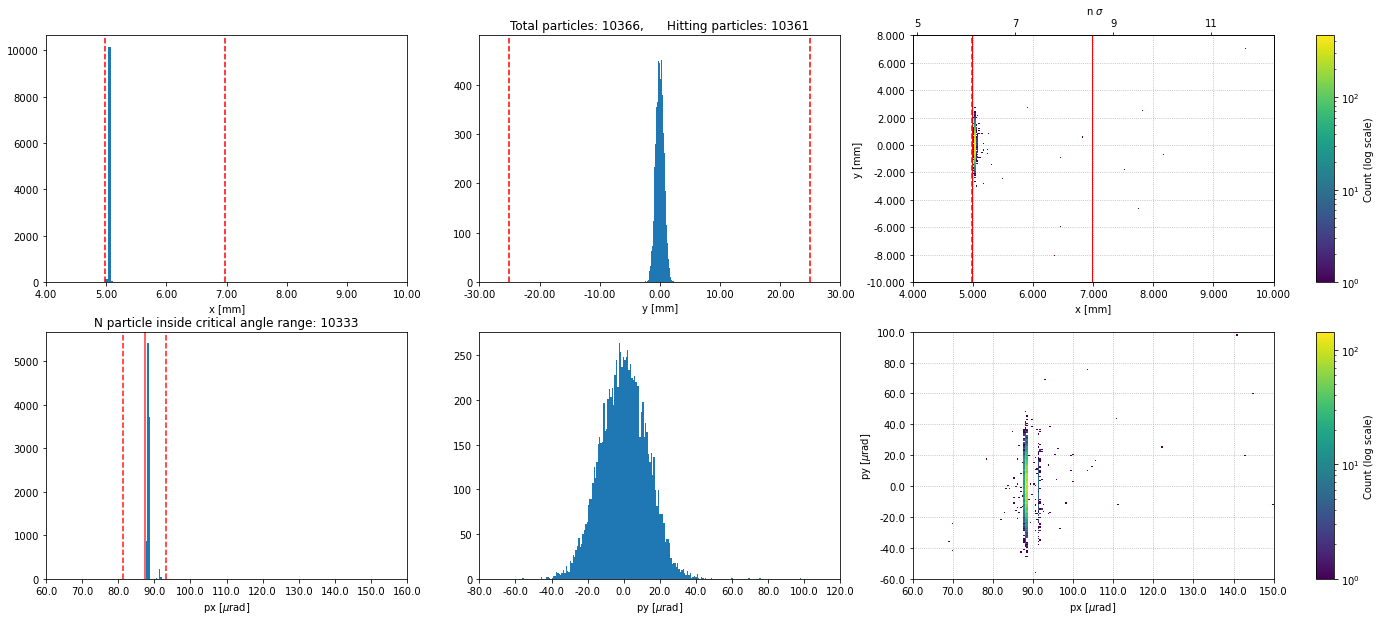

In [139]:
CRY_loc.compute_impact_particles(xpcrit = True)

In [113]:
CRY_loc.impact_part().px.iloc[0] #- CRY_loc.align_angle

8.8207205e-05

In [128]:
CRY_loc.CRY_sim_chann_eff

0.8988258805895578

In [129]:
CRY_loc.channeling_efficiency_sim()

Channeling efficiency: 0.897


In [140]:
CRY_loc.count_interactions()

interactions
['CH']                                            8466
['VRCH', 'MCS']                                   1083
['CH', 'DCH', 'MCS']                               397
['CH', 'DCH', 'MCS', 'VR', 'MCS']                  369
['MCS', 'VR', 'MCS']                                19
['VRCH', 'MCS', 'A']                                 7
nan                                                  5
['MCS']                                              5
['VRCH', 'MCS', 'PN', 'MCS', 'VR', 'MCS']            2
['AMVR', 'MCS']                                      2
['CH', 'DCH', 'MCS', 'VC', 'CH']                     2
['CH', 'DCH', 'MCS', 'A']                            1
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'PN', 'MCS']       1
['MCS', 'VRAM', 'MCS']                               1
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A']               1
['CH', 'DCH', 'MCS', 'VC', 'VRCH', 'MCS']            1
['VRCH', 'MCS', 'PN', 'MCS']                         1
['VRCH', 'MCS', 'PP', 'MCS']                        

In [130]:
CRY_loc.count_interactions()

interactions
['CH']                               14392
['VRCH', 'MCS']                       1550
['MCS', 'VR', 'MCS']                   192
['CH', 'DCH', 'MCS']                    60
['CH', 'DCH', 'MCS', 'VR', 'MCS']       35
['MCS']                                 24
['VRCH', 'MCS', 'A']                    11
nan                                      7
['AMVR', 'MCS']                          2
['MCS', 'VR', 'MCS', 'A']                2
['MCS', 'A']                             1
['MCS', 'VC', 'VRCH', 'MCS']             1
['VRCH', 'MCS', 'PN', 'MCS']             1
Name: interactions, dtype: int64

 ---- Total interacting particles: 16271 ---- 



In [141]:
LIN_SCAN_loc.load_particles('', file_name='particles_B2H.h5', Condor = False,
                      default_path = "./Outputdata/", df_key= 'LIN_SCAN_impacts')

There are repeated particle ids!


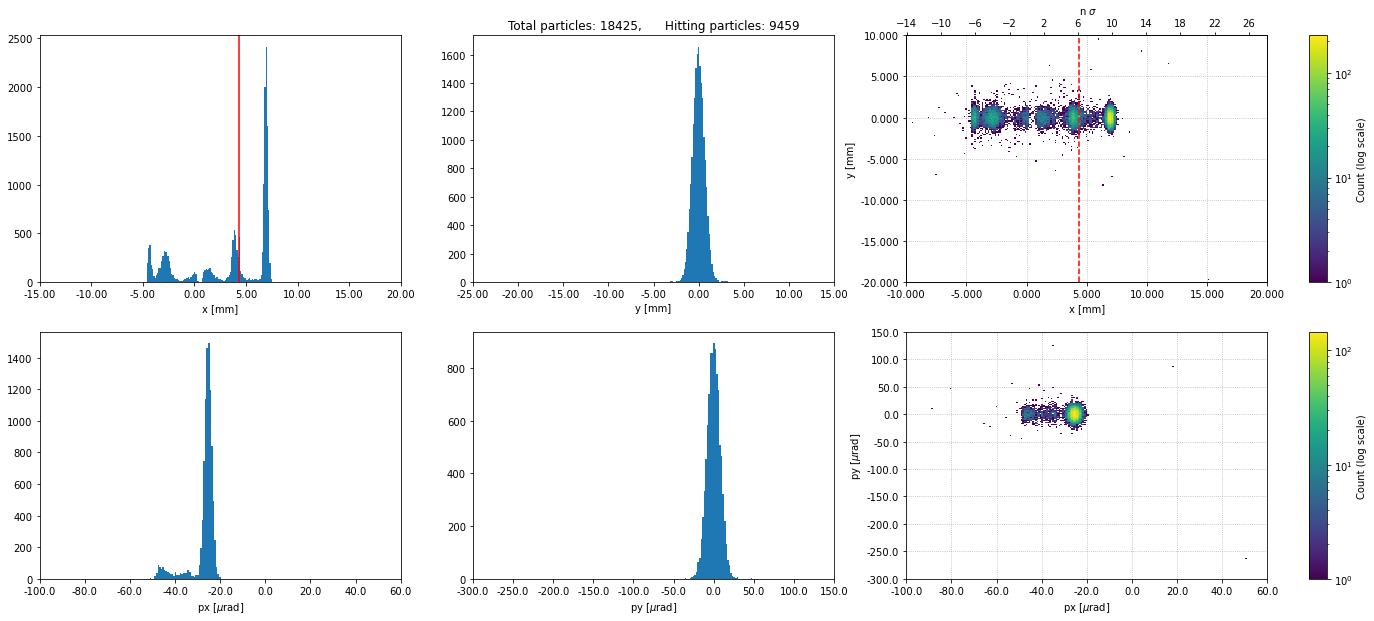

In [142]:
LIN_SCAN_loc.compute_impact_particles()

In [133]:
LIN_SCAN_loc.data

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,CRY_turn,interactions
0,-1.228413e-07,0.003845,-0.000053,-0.000999,-0.000001,-1.335810e-08,0,0,tcsg.b4r7.b2,12,"[0, 7]",NaN
1,-3.800852e-05,-0.002791,0.000005,0.001290,0.000017,-1.226320e-08,1,0,tcsg.b4r7.b2,12,"[0, 7]",NaN
2,-7.898201e-05,-0.002805,0.000050,0.000079,-0.000011,-1.259608e-08,2,0,tcsg.b4r7.b2,12,"[0, 7]",NaN
3,-1.161134e-04,0.003899,-0.000026,-0.001373,-0.000010,-1.462099e-08,3,0,tcsg.b4r7.b2,12,"[0, 7]",NaN
4,-1.501252e-04,0.001345,-0.000041,0.000942,0.000018,-1.834114e-08,4,0,tcsg.b4r7.b2,12,"[0, 7]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
395673,-1.549815e-04,0.001482,-0.000042,-0.000904,-0.000012,-8.223460e-09,4,9998,tcspm.b4r7.b2,7,"[0, 7]",NaN
395674,-1.951860e-04,-0.004279,0.000038,-0.000067,0.000008,-1.361883e-08,5,9998,tcspm.b4r7.b2,7,"[0, 7]",NaN
395675,-2.336208e-04,0.000141,0.000027,0.000987,0.000007,-2.050343e-08,6,9998,tcspm.b4r7.b2,7,"[0, 7]",NaN
395676,-2.687064e-04,0.005968,-0.000034,-0.000644,-0.000013,-8.515022e-07,7,9998,tcspm.b4r7.b2,7,"[0, 7]",[MCS]


In [120]:
CRY_loc.data['interactions'] = CRY_loc.data['interactions'].apply(lambda x: str(x))
vp_ch = set(CRY_loc.data[CRY_loc.data.interactions =="['CH']"][['particle_id', 'this_turn']].apply(tuple, axis=1))
m_ch= (LIN_SCAN_loc.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_ch))
LIN_SCAN_loc.data[m_ch]

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,CRY_turn,interactions
0,-1.728535e-07,0.006647,-0.000028,-0.000999,-1.385219e-06,-0.000001,0,0,tcsg.b4r7.b2,0,[0],"[MCS, A]"
1,-1.819937e-07,0.006919,-0.000026,-0.001153,-1.054776e-05,-0.000001,0,1,tcsg.b4r7.b2,0,[0],"[MCS, A]"
2,-1.936959e-07,0.007277,-0.000022,0.000163,-9.260378e-07,-0.000001,0,2,tcsg.b4r7.b2,0,[0],"[MCS, A]"
4,-1.683033e-07,0.006572,-0.000029,-0.001014,-5.530084e-06,-0.000001,0,4,tcsg.b4r7.b2,0,[0],"[MCS, A]"
5,-1.781260e-07,0.006808,-0.000027,0.000243,-4.413757e-06,-0.000001,0,5,tcsg.b4r7.b2,0,[0],"[MCS, A]"
...,...,...,...,...,...,...,...,...,...,...,...,...
18420,-1.749152e-07,0.006783,-0.000027,0.000238,4.538352e-06,-0.000001,0,9995,tcsg.b4r7.b2,0,[0],"[MCS, A]"
18421,-1.793635e-07,0.006920,-0.000026,0.000228,3.015639e-06,-0.000001,0,9996,tcsg.b4r7.b2,0,[0],"[MCS, A]"
18422,-1.814987e-07,0.006947,-0.000025,0.000897,7.019477e-06,-0.000001,0,9997,tcspm.b4r7.b2,0,[0],[MCS]
18423,-1.758405e-07,0.006722,-0.000027,0.000358,-4.301788e-06,-0.000001,0,9998,tcsg.b4r7.b2,0,[0],"[MCS, A]"


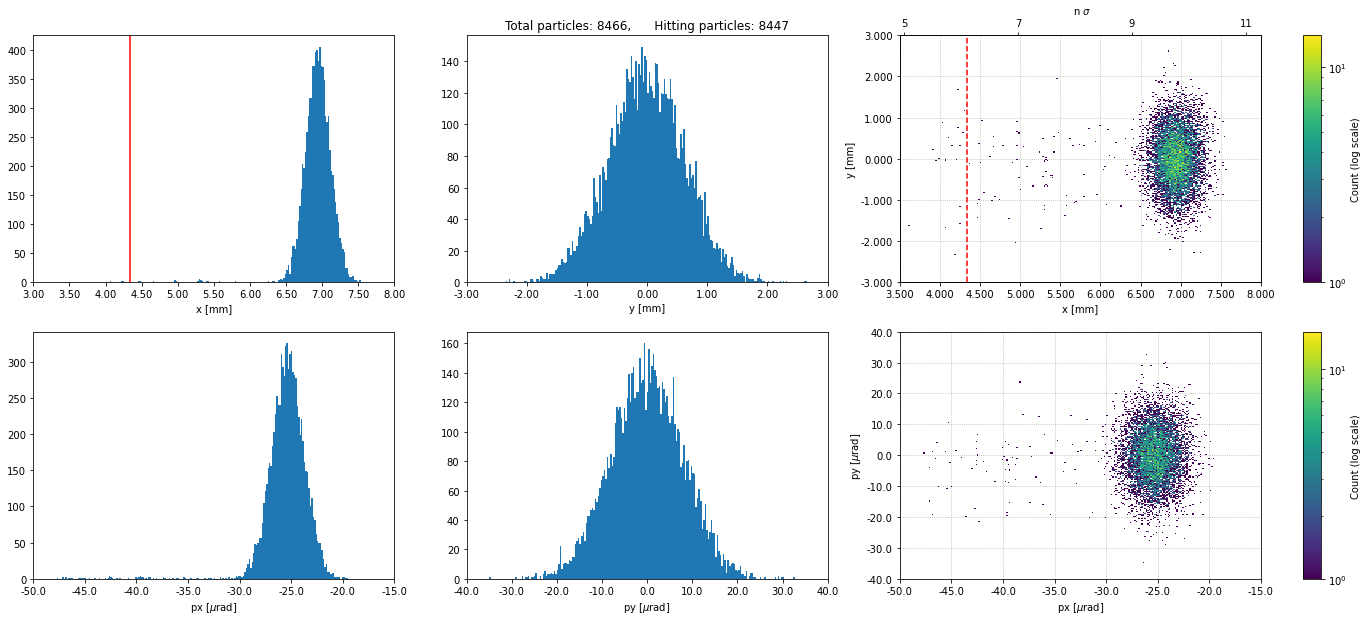

ValueError: too many values to unpack (expected 2)

In [121]:
fig, ax = LIN_SCAN_loc.plot_distributions(LIN_SCAN_loc.data[m_ch]['x'], LIN_SCAN_loc.data[m_ch]['y'], LIN_SCAN_loc.data[m_ch]['px'], LIN_SCAN_loc.data[m_ch]['py'], return_fig = True)

In [38]:
def plot_y(CRY_OBJ, COLL_OBJ, low_lim = -0.005 , high_lim  = 0.008):
    CRY_OBJ.data['interactions'] = CRY_OBJ.data['interactions'].apply(lambda x: str(x))
    vp_xp = set(CRY_OBJ.inside_xp_crit()[['particle_id', 'this_turn']].apply(tuple, axis=1))
    vp_ch = set(CRY_OBJ.data[CRY_OBJ.data.interactions =="['CH']"][['particle_id', 'this_turn']].apply(tuple, axis=1))
    m_ch= (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_ch))
    m_xp = (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_xp))

    m_ch_xp = m_ch & m_xp
    m_ch_nxp = m_ch & ~m_xp
    m_nch_xp = ~m_ch & m_xp
    m_nch_nxp = ~m_ch & ~m_xp

    print("Check total: ", sum(m_ch_xp)+sum(m_ch_nxp)+sum(m_nch_xp)+sum(m_nch_nxp) == len(COLL_OBJ.data))
    print("Check ch not xp: ", sum(m_ch_nxp) == 0)
    print("Check ch xp: ", sum(m_ch_xp) ==len(CRY_OBJ.data[CRY_OBJ.data.interactions =="['CH']"]))
    print("Check absorbed: ", len(CRY_OBJ.data[CRY_OBJ.data['interactions'].str.contains('A', case=True, na=False)]) == CRY_OBJ.n_CRY_absorbed)

    vp_strange = set(COLL_OBJ.data[m_xp][['particle_id', 'this_turn']].apply(tuple, axis=1))
    m_strange = (CRY_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_strange))
    diff = CRY_OBJ.inside_xp_crit().ne(CRY_OBJ.data[m_strange])
    a = CRY_OBJ.inside_xp_crit()[diff].dropna()

    ch_lost = len(a[a.interactions =="['CH']"])
    print("Number of particles channelled but lost before TCLA: ", ch_lost)
    n_lost = len(a) - ch_lost
    print("Number of particles in xp_crit but lost before TCLA: ", len(a) - ch_lost)
    abs_insidexp =  len(a[a['interactions'].str.contains('A', case=True, na=False)])
    print('Among which absorbed: ', abs_insidexp)
    b = CRY_OBJ.impact_part()[~(CRY_OBJ.impact_part()['py'] > CRY_OBJ.align_angle - np.abs(CRY_OBJ.xp_crit)) & (CRY_OBJ.impact_part()['py'] < CRY_OBJ.align_angle  + np.abs(CRY_OBJ.xp_crit))]
    abs_outsidexp = len(b[b['interactions'].str.contains('A', case=True, na=False)])
    print('Absorbed outside xp_crit: ', abs_outsidexp)
    print("Check single pass channeling efficiency: ", sum(m_ch_xp)/ (sum(m_ch_xp) + sum(m_nch_xp) + len(a)), CRY_OBJ.CRY_sim_chann_eff)
    #vp_comeback = set(CRY_OBJ.data[~(CRY_OBJ.data.CRY_turn.apply(lambda x: x[-1])== CRY_OBJ.data.this_turn)][['particle_id', 'this_turn']].apply(tuple, axis=1))
    #m_comeback = (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_comeback))
    #vp_imp = set(CRY_OBJ.impact_part()[['particle_id', 'this_turn']].apply(tuple, axis=1))
    #m_imp = (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_imp))

    dim = 'y' if COLL_OBJ.plane == 'V' else 'x'
    print(dim)

    my = (COLL_OBJ.data[dim] > low_lim) & (COLL_OBJ.data[dim] < high_lim)
    mt = COLL_OBJ.data.this_turn == 0
    tot  = len(COLL_OBJ.data)#COLL_OBJ.n_jobs * COLL_OBJ.part_per_job


    fig, ax = plt.subplots(figsize=(8, 5))

    ax.axvline(COLL_OBJ.jaw_L, color='k', label='Jaw limit')
    _ = ax.hist([COLL_OBJ.data[m_nch_xp& my][dim],

                COLL_OBJ.data[m_ch_xp & ~mt & my][dim], 
                COLL_OBJ.data[m_ch_xp & mt & my][dim],  
                COLL_OBJ.data[m_nch_nxp &  my ][dim],
                #COLL_OBJ.data[m_nch_nxp & my & m_imp][dim] 
                ],
                bins=400,  alpha = 0.8,  
                label=[f'XP: ok,   ({len(COLL_OBJ.data[m_nch_xp & my].y)/tot*100:.{2}f}%)', 
                    #f'XP: ok, CB: no ({len(COLL_OBJ.data[m_nch_xp & ~m_comeback & my].y)/tot*100:.{2}f}%)', 
                    f'CH T>0 ({len(COLL_OBJ.data[m_ch_xp & ~mt & my].y)/tot*100:.{2}f}%)', 
                    f'CH T=0 ({len(COLL_OBJ.data[m_ch_xp & mt & my].y)/tot*100:.{2}f}%)', 
                    #f'XP: no, hit: no({len(COLL_OBJ.data[m_nch_nxp &~m_imp & my].y)/tot*100:.{2}f}%)', 
                    #f'XP: no, hit:ok ({len(COLL_OBJ.data[m_nch_nxp & m_imp & my].y)/tot*100:.{2}f}%)',
                    
                        ], 
                color=['#000080', '#054907', '#15B01A', 'orange',], #,  'red'],            
                stacked = True)
    

    ax.legend()


    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    

Check total:  True
Check ch not xp:  True
Check ch xp:  False
Check absorbed:  False
Number of particles channelled but lost before TCLA:  188
Number of particles in xp_crit but lost before TCLA:  11
Among which absorbed:  11
Absorbed outside xp_crit:  16
Check single pass channeling efficiency:  0.8850395663281201 0.8988258805895578
x


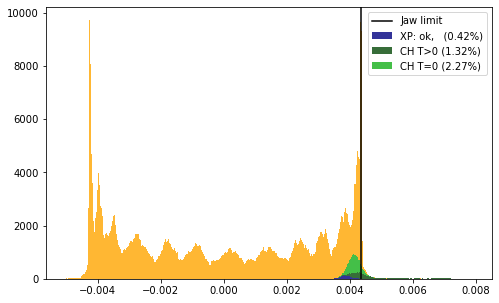

In [135]:
plot_y(CRY_loc, LIN_SCAN_loc)


Check total:  True
Check ch not xp:  True
Check ch xp:  True
Check absorbed:  False
Number of particles channelled but lost before TCLA:  0
Number of particles in xp_crit but lost before TCLA:  9
Among which absorbed:  9
Absorbed outside xp_crit:  11
Check single pass channeling efficiency:  0.8193167521532952 0.819713400464756
x


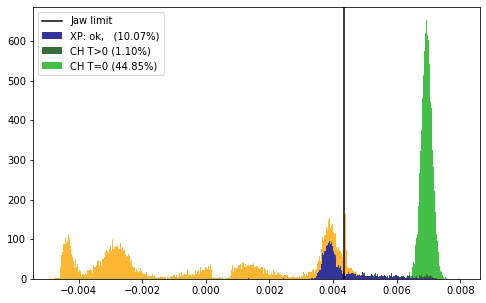

In [143]:
plot_y(CRY_loc, LIN_SCAN_loc)

In [69]:
CRY_loc.count_interactions()

interactions
['CH']                               14392
['VRCH', 'MCS']                       1550
['MCS', 'VR', 'MCS']                   192
['CH', 'DCH', 'MCS']                    60
['CH', 'DCH', 'MCS', 'VR', 'MCS']       35
['MCS']                                 24
['VRCH', 'MCS', 'A']                    11
nan                                      7
['AMVR', 'MCS']                          2
['MCS', 'VR', 'MCS', 'A']                2
['MCS', 'A']                             1
['MCS', 'VC', 'VRCH', 'MCS']             1
['VRCH', 'MCS', 'PN', 'MCS']             1
Name: interactions, dtype: int64

 ---- Total interacting particles: 16271 ---- 



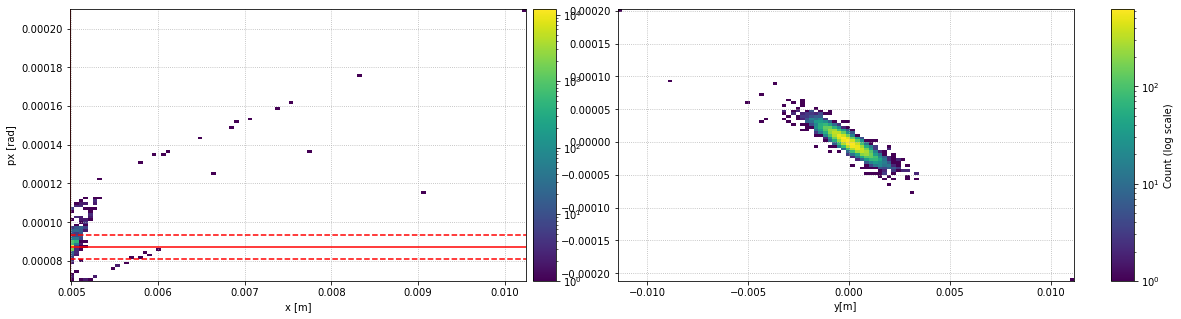

In [68]:
CRY_loc.plot_phasespace()

In [26]:
CRY_loc.impact_part()


,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,CRY_turn,interactions
0,-1.355253e-20,0.004980,0.000087,-0.001828,3.349147e-05,0.000000e+00,0,0,tcsg.b4r7.b2,7,[0],[CH]
1,0.000000e+00,0.004980,0.000087,-0.000117,1.044223e-05,0.000000e+00,0,1,tcspm.b4r7.b2,57,"[0, 50]",[CH]
2,-1.640343e-03,0.004984,0.000087,0.000194,-1.171721e-05,-1.777837e-06,50,1,tcspm.b4r7.b2,57,"[0, 50]",[CH]
3,-1.355253e-20,0.004980,0.000087,0.000142,-8.729745e-07,0.000000e+00,0,2,alive,200,[0],[CH]
4,0.000000e+00,0.004980,0.000087,0.000216,-8.246261e-06,0.000000e+00,0,3,tcsg.b4r7.b2,7,[0],[CH]
...,...,...,...,...,...,...,...,...,...,...,...,...
1554,-6.776264e-21,0.004980,0.000087,-0.000783,8.320661e-06,0.000000e+00,0,997,tcsg.b4r7.b2,12,"[0, 7]",[CH]
1555,-2.663616e-04,0.005038,0.000090,-0.001018,2.041902e-05,-3.215453e-08,7,997,tcsg.b4r7.b2,12,"[0, 7]","[MCS, VR, MCS]"
1556,0.000000e+00,0.004980,0.000087,-0.000268,8.300223e-06,0.000000e+00,0,998,alive,200,[0],[CH]
1557,-6.776264e-21,0.004980,0.000087,-0.000290,-1.977004e-07,0.000000e+00,0,999,tcsg.b4r7.b2,12,"[0, 7]",[CH]


IMPACT ON TCCS AT TURN  7


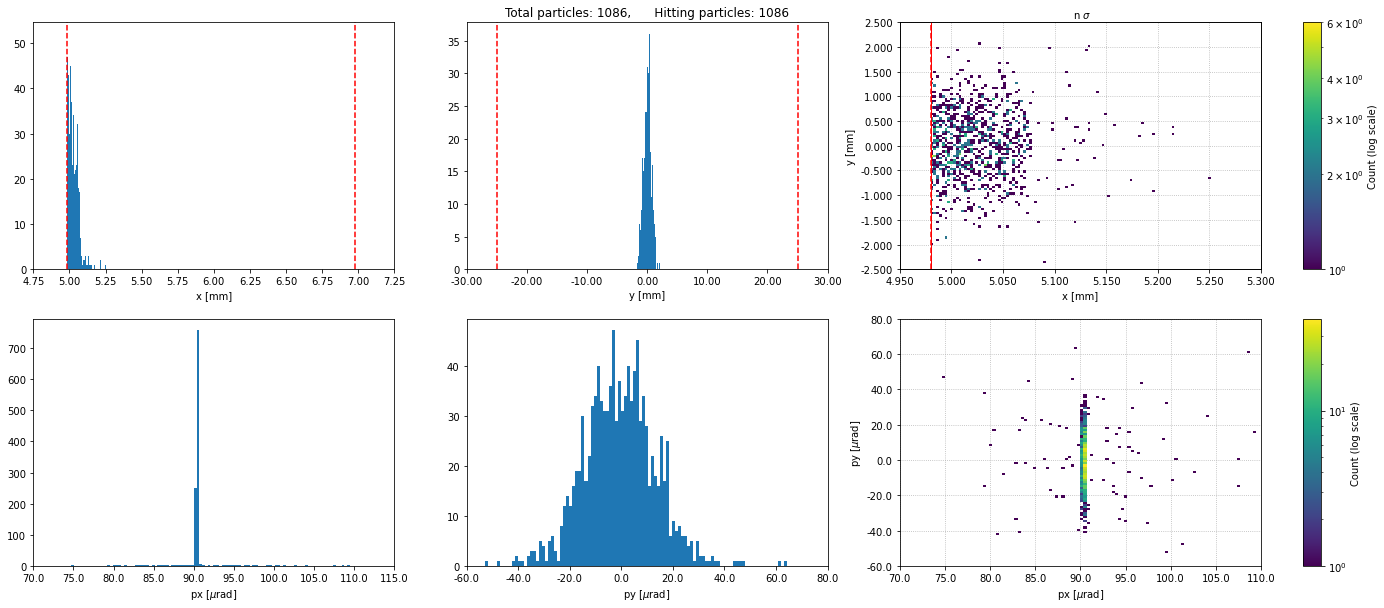

In [72]:
plot_at_turn_simple(CRY_loc, 7)

Delta angle 3.762631193864708e-06


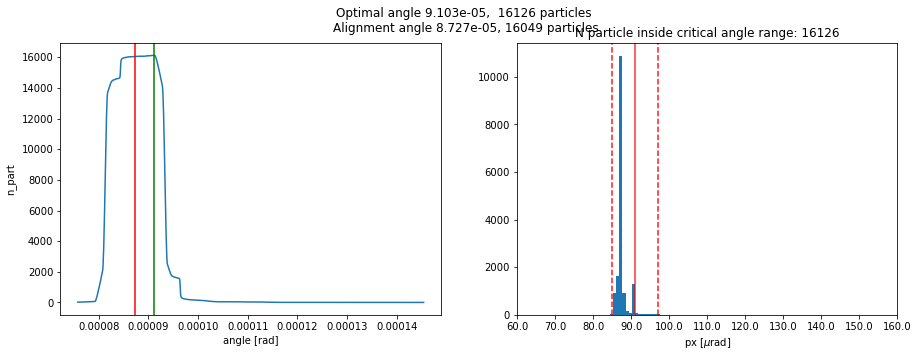

In [73]:
CRY_loc.optimize_alignment()

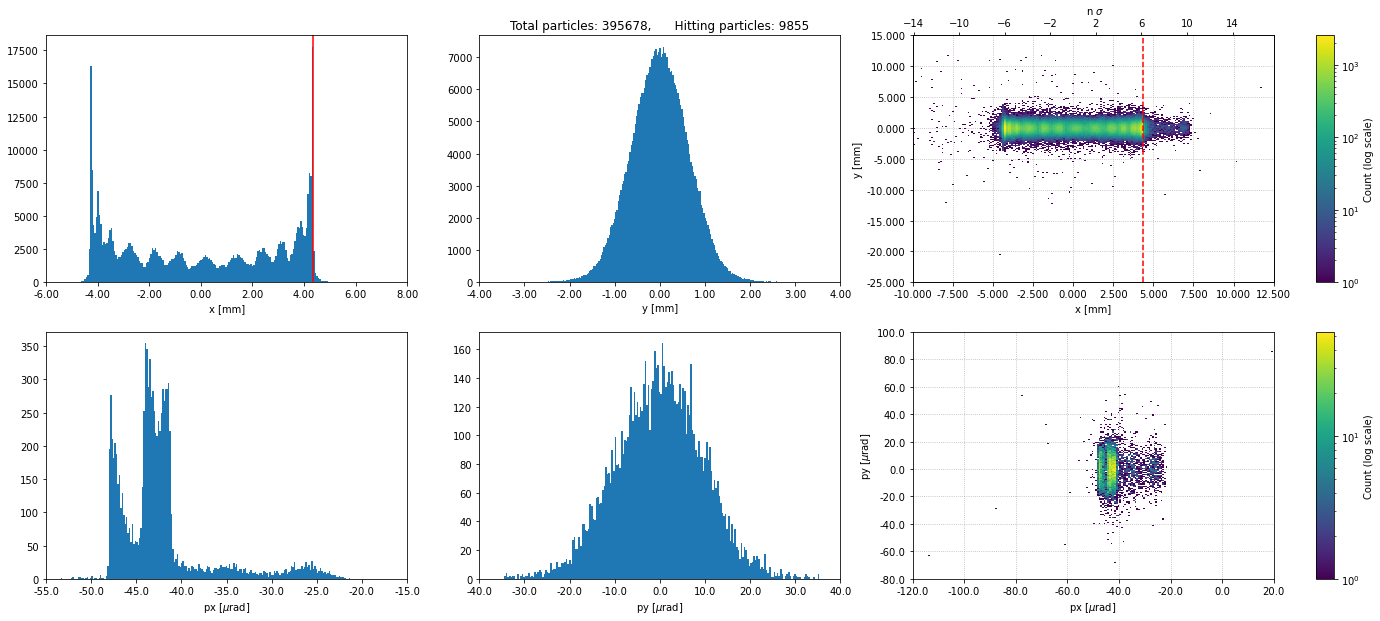

In [74]:
LIN_SCAN_loc.compute_impact_particles(percentile = 0.1)

In [76]:
LIN_SCAN_loc.count_interactions()

interactions
['MCS', 'A']                                                                     6537
['MCS', 'C', 'MCS', 'A']                                                            1
['MCS', 'C', 'MCS']                                                                 1
['MCS', 'PN', 'MCS', 'A']                                                         812
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'A']                                            104
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PN', 'MCS', 'A']                                 6
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PN', 'MCS', 'PN', 'MCS']                         3
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PN', 'MCS', 'PP', 'MCS', 'A']                    1
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PN', 'MCS', 'SD', 'MCS']                         1
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PN', 'MCS']                                      8
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PP', 'MCS', 'A']                                 4
['MCS', 'PN', 'MCS', 'PN', 'MCS', 'PP', '

In [77]:
LIN_SCAN_loc.impact_part()

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,CRY_turn,interactions
0,-1.828964e-07,0.006965,-0.000025,0.000049,5.198876e-06,-0.000001,0,0,tcsg.b4r7.b2,0,[0],"[MCS, A]"
1,-1.830528e-07,0.006696,-0.000028,0.000873,1.665007e-05,-0.000001,0,1,tcsg.b4r7.b2,0,[0],"[MCS, A]"
2,-1.821984e-07,0.006971,-0.000025,0.000124,-2.859467e-06,-0.000001,0,2,tcsg.b4r7.b2,0,[0],"[MCS, A]"
3,-1.743644e-07,0.006773,-0.000027,-0.000355,1.216525e-07,-0.000001,0,3,tcsg.b4r7.b2,0,[0],"[MCS, A]"
4,-1.766443e-07,0.006829,-0.000026,0.000214,-1.793588e-06,-0.000001,0,4,tcsg.b4r7.b2,0,[0],"[MCS, A]"
...,...,...,...,...,...,...,...,...,...,...,...,...
16298,-1.806337e-07,0.006922,-0.000025,-0.000136,-4.907720e-06,-0.000001,0,9995,tcsg.b4r7.b2,0,[0],"[MCS, A]"
16299,-1.855420e-07,0.007001,-0.000025,0.000717,-9.012255e-07,-0.000001,0,9996,tcsg.b4r7.b2,0,[0],"[MCS, A]"
16300,-1.750218e-07,0.006761,-0.000027,-0.000102,-5.114943e-06,-0.000001,0,9997,tcsg.b4r7.b2,0,[0],"[MCS, A]"
16301,-1.833931e-07,0.007028,-0.000025,0.000232,2.427939e-06,-0.000001,0,9998,tcsg.b4r7.b2,0,[0],"[MCS, A]"


In [101]:
ls()

MD_1000GeV_LIN_SCAN_full_20241206-1457
MD_1000GeV_LIN_SCAN_full_20241206-1456
TWOCRYST_TCCS_lin_scan_450GeV_5000_noADT_20241205-1150
TWOCRYST_TCCS_lin_scan_450GeV_5000_ADT_20241205-1148
TWOCRYST_TCCS_lin_scan_450GeV_NoADT_20241204-1809
TWOCRYST_TCCS_lin_scan_450GeV_adt_noindkicks_20241204-1645
TWOCRYST_TCCS_lin_scan_450GeV_test_ADT_more_turns_20241204-1030
TWOCRYST_TCCS_lin_scan_450GeV_test_ADT_20241203-1758
TWOCRYST_TCCS_lin_scan_450GeV_full_data_20241202-1220
TWOCRYST_TCCS_450GeV_losses_closedTCLA_20241126-1052
TWOCRYST_TCCS_450GeV_losses_openTCLA_openTCT_20241126-1049
TWOCRYST_TCCS_450GeV_losses_openTCLA_closedTCT_20241126-1046
TWOCRYST_450GeV_DC_2025opt_circular_halo_20241122-0944
TWOCRYST_450GeV_DC_2025opt_circular_halo_20241121-1844
TWOCRYST_450GeV_DC_2025opt_halo_smaller_20241121-1741
TWOCRYST_3000GeV_DC_2025opt_halo_20241120-1734
TWOCRYST_1000GeV_DC_2025opt_halo_20241120-1733
TWOCRYST_450GeV_DC_2025opt_halo_20241120-1733
TWOCRYST_TCCP_lin_scan_450GeV_all_pix_20241118-1054
TWOCR

# Linear Scans

In [17]:
lin_scan100 = 'MD_1000GeV_LIN_SCAN_full_20241206-1457'
lin_scan450 = 'MD_1000GeV_LIN_SCAN_full_450_20241209-1810'
lin_scan3000 = 'MD_1000GeV_LIN_SCAN_full_3000_20241209-1811'
lin_scan5000 = 'MD_1000GeV_LIN_SCAN_full_5000_20241209-1811'

## 1000 GeV

In [17]:
CRY_ls1000 = CrystalAnalysis(plane='H', n_sigma=6.110539, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0144112698, miscut = -0.014324,sigma=0.0008148661018450332, jaw_L=0.00497979123700652)
ABS_ls1000 = TargetAnalysis(plane='H', n_sigma=6.110539, target_type='collimator', length=1,sigma=0.0007101460983541389, jaw_L=0.00433993122599885)

In [15]:
CRY_ls1000.load_particles(lin_scan100, 'CRY_impacts',  get_absorbed='all')

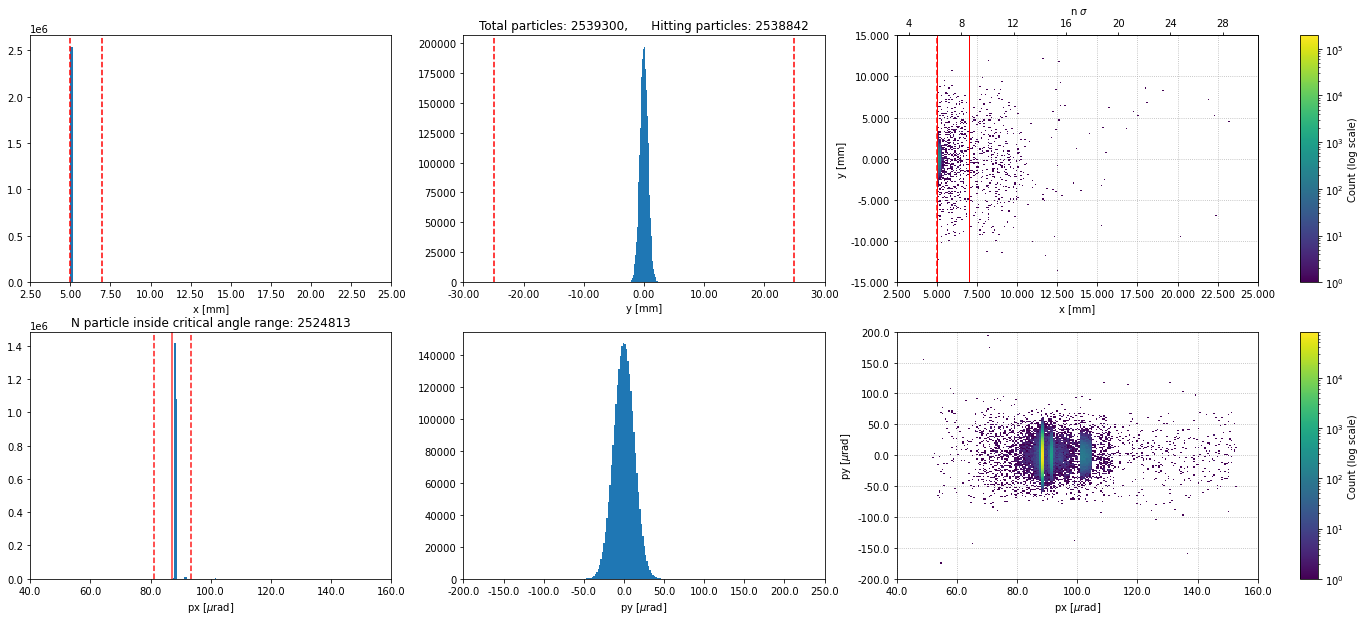

In [16]:
CRY_ls1000.compute_impact_particles(xpcrit = True)

In [18]:
ABS_ls1000.load_particles(lin_scan100, 'LIN_SCAN_impacts')

There are repeated particle ids!


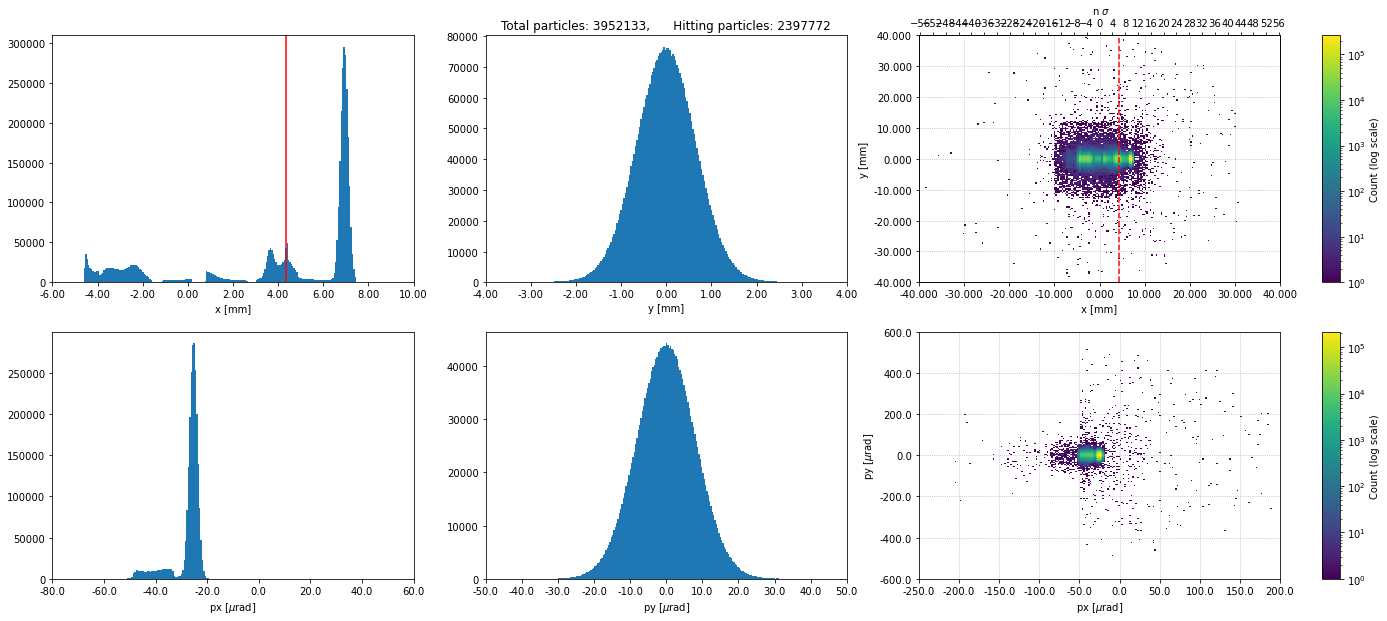

In [19]:
ABS_ls1000.compute_impact_particles(percentile = 0.1, log=False)

IMPACT ON TCCS AT TURN  7


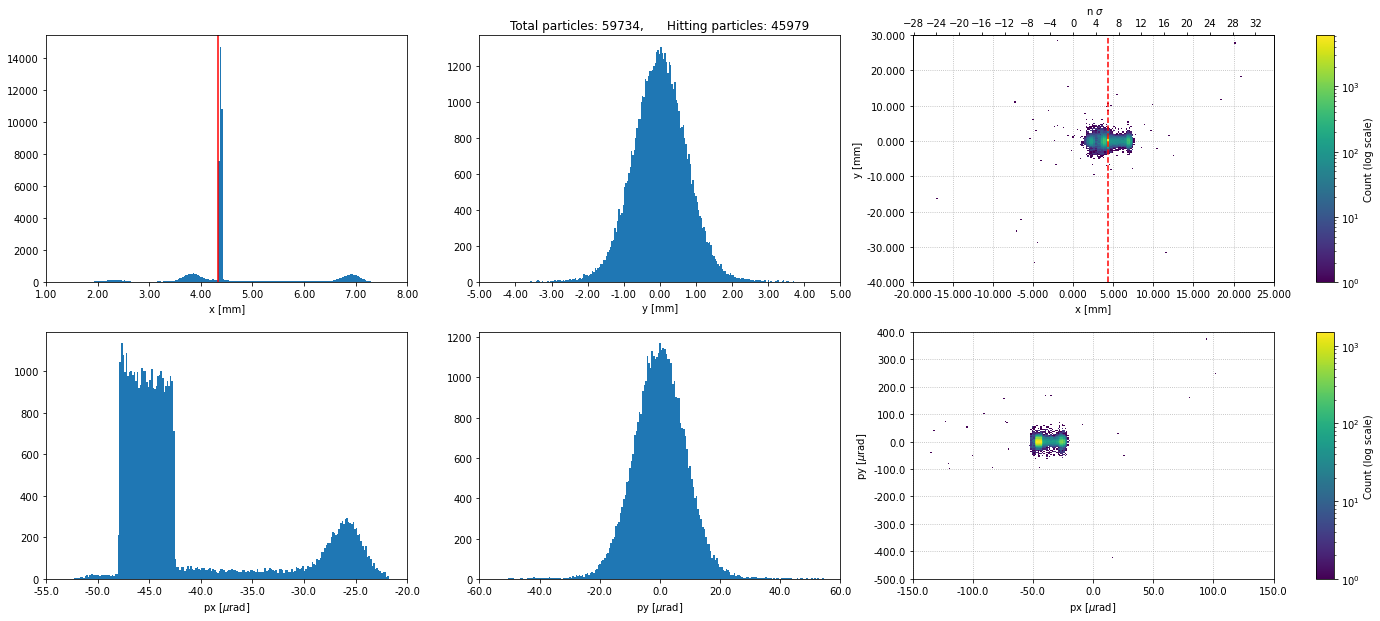

In [19]:
plot_at_turn_simple(ABS_ls1000, 7, percentile = 0.1)

Height:  0.8730173668769929  a.u.
Mean:  0.006939690858775296  mm
Sigma:  0.0001717598709508704  mm
Calculated theta [urad]:  49.622
Efficiency:  87.3 %


(-0.003, 0.009)

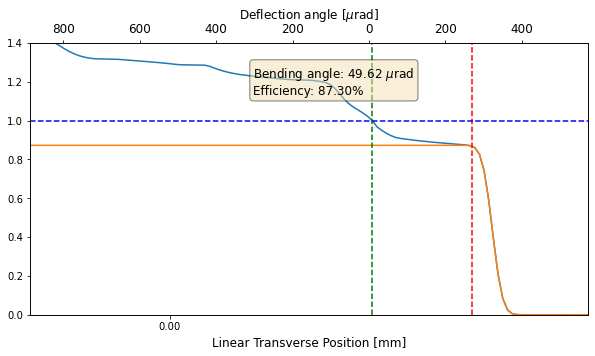

In [22]:
ax = ABS_ls1000.linear_scan(PosEnvelope=None, PosMaxErfFit= 6.5e-3, param0=[0.5, -1, 7e-3, 0.0002], CRY_name = CRY_name, COLL_name = LIN_name, config_file = './config_sim.yaml', return_fig=True, MD= 1000, save_data = True)
ax[1].set_xlim(-0.003, 0.009)


In [24]:
ABS_ls1000.get_twiss_for_linear_scan(CRY_name =  CRY_name, COLL_name = LIN_name, config_file = './config_sim.yaml', line_file= './line_sim.yaml', MD=1000)

(202.14286258643102, 151.98826396426932, 0.3320955267701499)

In [39]:
def plot_y(CRY_OBJ, COLL_OBJ, low_lim = -0.005 , high_lim  = 0.008):
    CRY_OBJ.data['interactions'] = CRY_OBJ.data['interactions'].apply(lambda x: str(x))
    vp_xp = set(CRY_OBJ.inside_xp_crit()[['particle_id', 'this_turn']].apply(tuple, axis=1))
    vp_ch = set(CRY_OBJ.data[CRY_OBJ.data.interactions =="['CH']"][['particle_id', 'this_turn']].apply(tuple, axis=1))
    m_ch= (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_ch))
    m_xp = (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_xp))

    m_ch_xp = m_ch & m_xp
    m_ch_nxp = m_ch & ~m_xp
    m_nch_xp = ~m_ch & m_xp
    m_nch_nxp = ~m_ch & ~m_xp

    print("Check total: ", sum(m_ch_xp)+sum(m_ch_nxp)+sum(m_nch_xp)+sum(m_nch_nxp) == len(COLL_OBJ.data))
    print("Check ch not xp: ", sum(m_ch_nxp) == 0)
    print("Check ch xp: ", sum(m_ch_xp) ==len(CRY_OBJ.data[CRY_OBJ.data.interactions =="['CH']"]))
    print("Check absorbed: ", len(CRY_OBJ.data[CRY_OBJ.data['interactions'].str.contains('A', case=True, na=False)]) == CRY_OBJ.n_CRY_absorbed)

    vp_strange = set(COLL_OBJ.data[m_xp][['particle_id', 'this_turn']].apply(tuple, axis=1))
    m_strange = (CRY_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_strange))
    diff = CRY_OBJ.inside_xp_crit().ne(CRY_OBJ.data[m_strange])
    a = CRY_OBJ.inside_xp_crit()[diff].dropna()

    ch_lost = len(a[a.interactions =="['CH']"])
    print("Number of particles channelled but lost before TCLA: ", ch_lost)
    n_lost = len(a) - ch_lost
    print("Number of particles in xp_crit but lost before TCLA: ", len(a) - ch_lost)
    abs_insidexp =  len(a[a['interactions'].str.contains('A', case=True, na=False)])
    print('Among which absorbed: ', abs_insidexp)
    b = CRY_OBJ.impact_part()[~(CRY_OBJ.impact_part()['py'] > CRY_OBJ.align_angle - np.abs(CRY_OBJ.xp_crit)) & (CRY_OBJ.impact_part()['py'] < CRY_OBJ.align_angle  + np.abs(CRY_OBJ.xp_crit))]
    abs_outsidexp = len(b[b['interactions'].str.contains('A', case=True, na=False)])
    print('Absorbed outside xp_crit: ', abs_outsidexp)
    print("Check single pass channeling efficiency: ", sum(m_ch_xp)/ (sum(m_ch_xp) + sum(m_nch_xp) + len(a)), CRY_OBJ.CRY_sim_chann_eff)
    vp_comeback = set(CRY_OBJ.data[~(CRY_OBJ.data.CRY_turn.apply(lambda x: x[-1])== CRY_OBJ.data.this_turn)][['particle_id', 'this_turn']].apply(tuple, axis=1))
    m_comeback = (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_comeback))
    vp_imp = set(CRY_OBJ.impact_part()[['particle_id', 'this_turn']].apply(tuple, axis=1))
    m_imp = (COLL_OBJ.data[['particle_id', 'this_turn']].apply(tuple, axis=1).isin(vp_imp))

    dim = 'y' if COLL_OBJ.plane == 'V' else 'x'

    my = (COLL_OBJ.data[dim] > low_lim) & (COLL_OBJ.data[dim] < high_lim)
    mt = COLL_OBJ.data.this_turn == 0
    tot  = len(COLL_OBJ.data)#COLL_OBJ.n_jobs * COLL_OBJ.part_per_job


    fig, ax = plt.subplots(figsize=(8, 5))

    ax.axvline(COLL_OBJ.jaw_L, color='k', label='Jaw limit')
    _ = ax.hist([COLL_OBJ.data[m_nch_xp & m_comeback  & my][dim],
                COLL_OBJ.data[m_nch_xp & ~m_comeback & my][dim],
                COLL_OBJ.data[m_ch_xp & ~mt & my][dim], 
                COLL_OBJ.data[m_ch_xp & mt & my][dim],  
                COLL_OBJ.data[m_nch_nxp &  my & ~m_imp][dim],
                COLL_OBJ.data[m_nch_nxp & my & m_imp][dim] 
                ],
                bins=400,  alpha = 0.8,  
                label=[f'XP: ok, CB: ok,  ({len(COLL_OBJ.data[m_nch_xp & m_comeback & my].y)/tot*100:.{2}f}%)', 
                    f'XP: ok, CB: no ({len(COLL_OBJ.data[m_nch_xp & ~m_comeback & my].y)/tot*100:.{2}f}%)', 
                    f'CH T>0 ({len(COLL_OBJ.data[m_ch_xp & ~mt & my].y)/tot*100:.{2}f}%)', 
                    f'CH T=0 ({len(COLL_OBJ.data[m_ch_xp & mt & my].y)/tot*100:.{2}f}%)', 
                    f'XP: no, hit: no({len(COLL_OBJ.data[m_nch_nxp &~m_imp & my].y)/tot*100:.{2}f}%)', 
                    f'XP: no, hit:ok ({len(COLL_OBJ.data[m_nch_nxp & m_imp & my].y)/tot*100:.{2}f}%)',
                    
                        ], 
                color=['#000080', '#069AF3',  '#054907', '#15B01A', 'orange', 'red'],            
                stacked = True)
    ax.text(-0.005, 80000, f'Lost before TCLA: {n_lost/(COLL_OBJ.n_jobs * COLL_OBJ.part_per_job)*100:.{2}f}%')
    ax.text(-0.005, 75000, f'Absorbed: {CRY_OBJ.n_CRY_absorbed/(COLL_OBJ.n_jobs * COLL_OBJ.part_per_job)*100 :.{2}f}%')
    ax.text(-0.005, 60000, f'Alive: {len(COLL_OBJ.data[COLL_OBJ.data.at_element=="alive"])/(COLL_OBJ.n_jobs * COLL_OBJ.part_per_job)*100:.{2}f} %')
    ax.text(-0.005, 55000, f'Single pass chann eff: {100*sum(m_ch_xp)/ (sum(m_ch_xp) + sum(m_nch_xp) + n_lost - ch_lost):.{2}f} %')

    ax.legend()


    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    new_A, mu, sigma = normalize_histograms(ax,COLL_OBJ.erf_params[1], COLL_OBJ.erf_params[2], COLL_OBJ.erf_params[3] )
    ax.plot(x, gaussian(x, new_A, COLL_OBJ.erf_params[2], COLL_OBJ.erf_params[3]), color='r')

Check total:  True
Check ch not xp:  False
Check ch xp:  False
Check absorbed:  True
Number of particles channelled but lost before TCLA:  1
Number of particles in xp_crit but lost before TCLA:  3243
Among which absorbed:  3099
Absorbed outside xp_crit:  3246
Check single pass channeling efficiency:  0.8235473280595434 0.8236416827130317


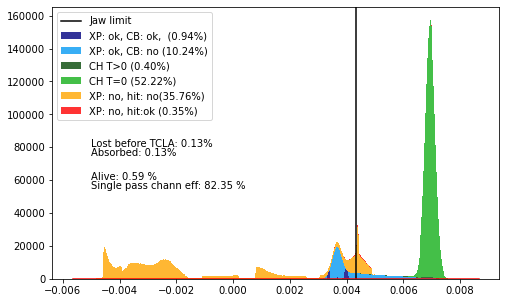

In [22]:
plot_y(CRY_ls1000, ABS_ls1000)

IMPACT ON TCCS AT TURN  0


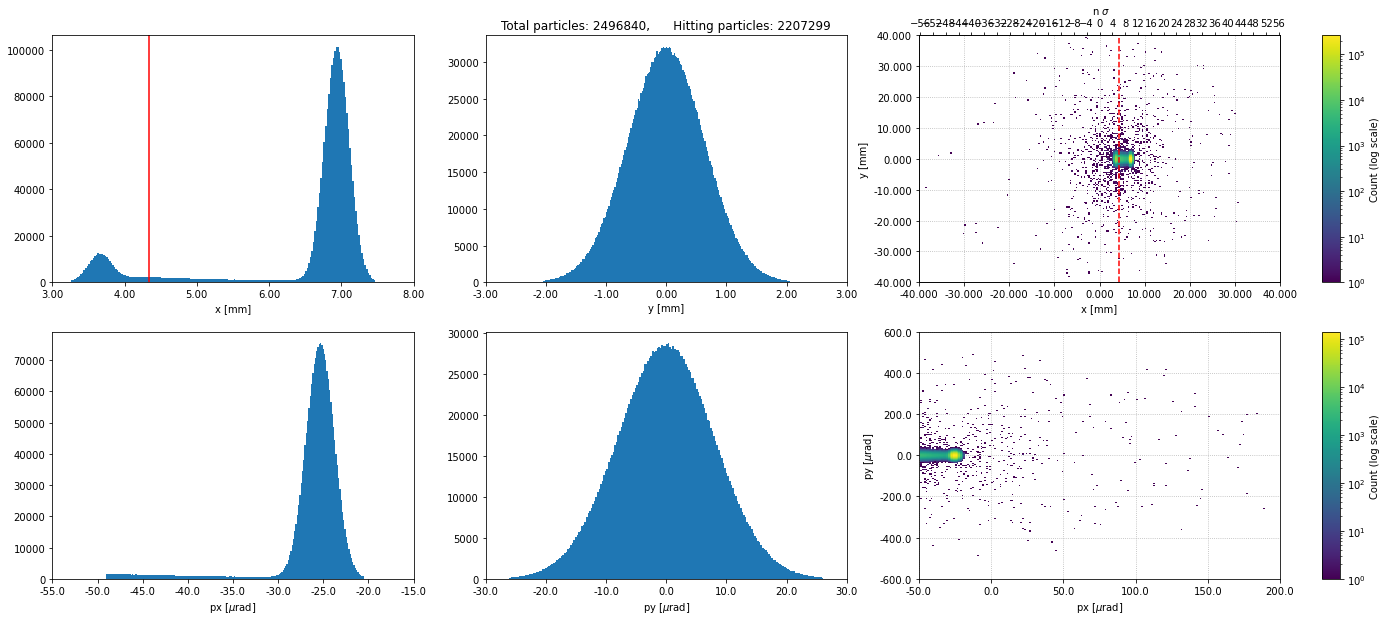

In [93]:
plot_at_turn_simple(ABS_ls1000, 0, percentile = 0.1)

## 450 GeV

In [18]:
CRY_ls450 = CrystalAnalysis(plane='H', n_sigma=6.03665, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0144525418, miscut = -0.014324,sigma=0.001214925952193352, jaw_L=0.007334604717154749)
ABS_ls450 = TargetAnalysis(plane='H', n_sigma=6.03665, target_type='collimator', length=1,sigma=0.0010587937506844319, jaw_L=0.006392125577205032)

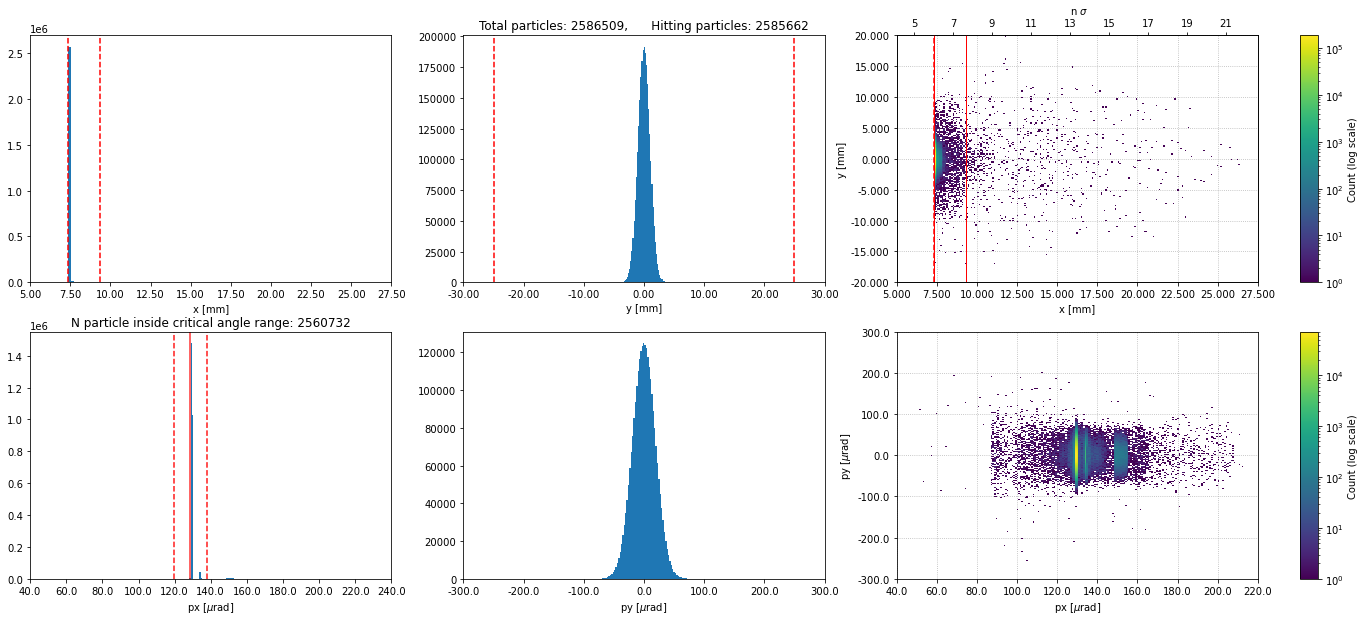

In [19]:
CRY_ls450.load_particles(lin_scan450, 'CRY_impacts',  get_absorbed='all')
CRY_ls450.compute_impact_particles(xpcrit = True)

In [20]:
CRY_ls450.CRY_sim_chann_eff

0.8218889058757582

In [21]:
CRY_ls450.channeling_efficiency_sim()

Channeling efficiency: 0.822


In [22]:
CRY_ls450.count_interactions()

interactions
['CH']                                                         2104460
['MCS', 'VR', 'MCS']                                            206929
['CH', 'DCH', 'MCS']                                            134137
['CH', 'DCH', 'MCS', 'VR', 'MCS']                               126465
['MCS']                                                           3162
['MCS', 'VC', 'CH']                                               2704
['MCS', 'VR', 'MCS', 'A']                                         1639
['CH', 'DCH', 'MCS', 'VC', 'CH']                                  1556
['CH', 'DCH', 'MCS', 'A']                                          842
nan                                                                828
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A']                             747
['MCS', 'VR', 'MCS', 'PN', 'MCS']                                  599
['CH', 'DCH', 'MCS', 'PN', 'MCS']                                  348
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'PN', 'MCS']                  

There are repeated particle ids!


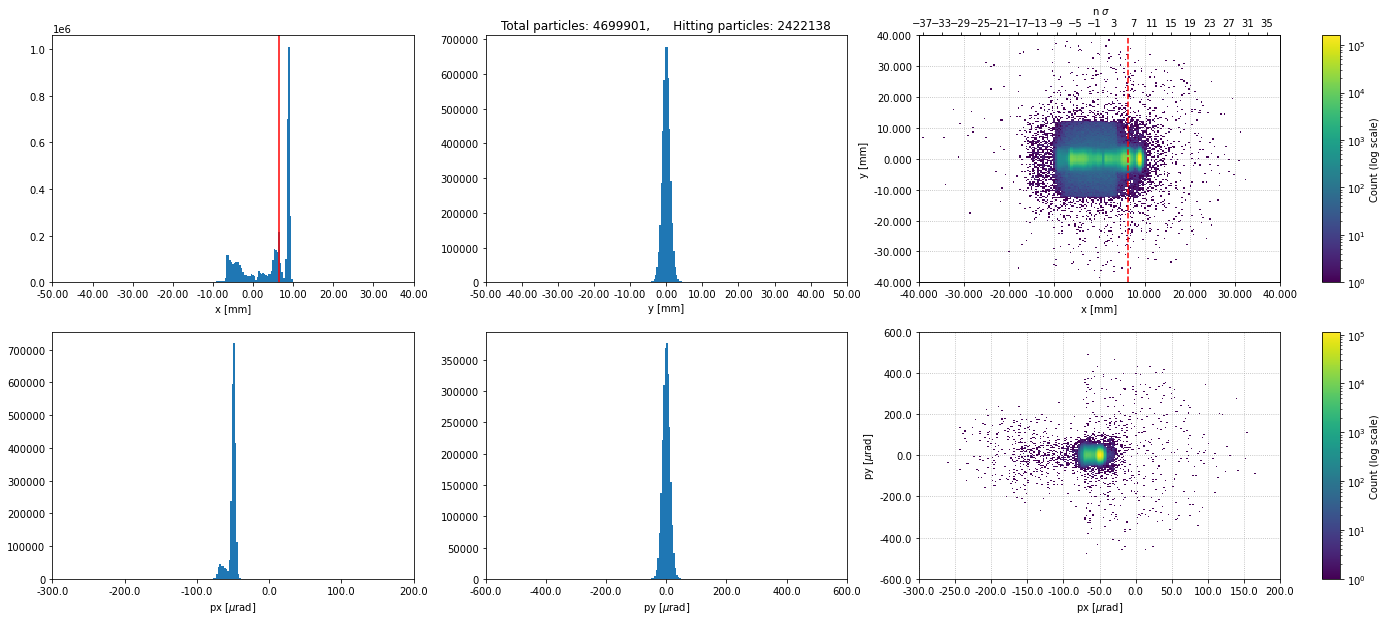

In [23]:
ABS_ls450.load_particles(lin_scan450, 'LIN_SCAN_impacts')
ABS_ls450.compute_impact_particles(xpcrit = True)

Height:  0.8566845837581156  a.u.
Mean:  0.0088810872583279  mm
Sigma:  0.0002607149231721351  mm
Calculated theta [urad]:  49.635
Efficiency:  85.67 %


(0.003, 0.011)

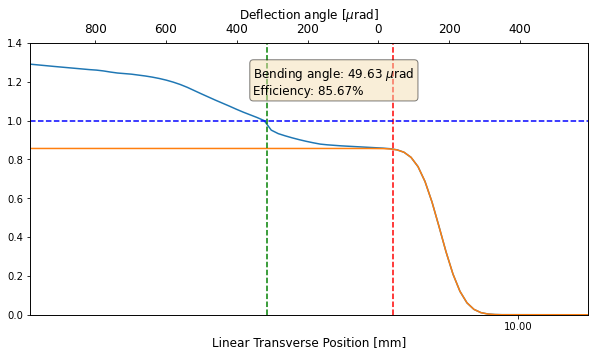

In [37]:
ax = ABS_ls450.linear_scan(PosEnvelope=None, PosMaxErfFit= 8.2e-3, param0=[0.5, -1, 8.2e-3, 0.0002], CRY_name = CRY_name, COLL_name = LIN_name, 
                                config_file = './config_sim.yaml', return_fig=True, MD= 450, save_data = True)
ax[1].set_xlim(0.003, 0.011)

In [25]:
ABS_ls450.get_twiss_for_linear_scan(CRY_name =  CRY_name, COLL_name = LIN_name, config_file = './config_sim.yaml', line_file= './line_sim.yaml', MD=450)

(202.14283985926235, 151.98832199133804, 0.33209548889087126)

Check total:  True
Check ch not xp:  False
Check ch xp:  False
Check absorbed:  True
Number of particles channelled but lost before TCLA:  5
Number of particles in xp_crit but lost before TCLA:  3664
Among which absorbed:  3193
Absorbed outside xp_crit:  3412
Check single pass channeling efficiency:  0.8218165743232795 0.8218889058757582


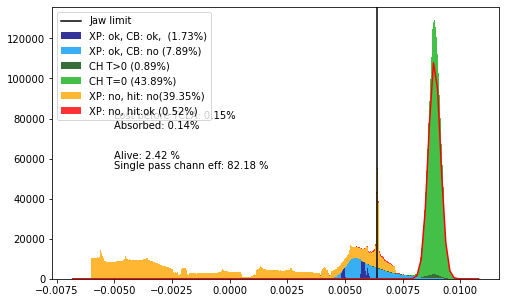

In [40]:
plot_y(CRY_ls450, ABS_ls450, low_lim=-0.006, high_lim=0.010)

## 3000 GeV

In [29]:
CRY_ls3000 = CrystalAnalysis(plane='H', n_sigma=6.037554, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0143737785, miscut = -0.014324,sigma=0.0004704161014142652, jaw_L=0.0028406819801725307)
ABS_ls3000 = TargetAnalysis(plane='H', n_sigma=6.037554, target_type='collimator', length=1,sigma=0.00040996200484082863, jaw_L=0.0024757226624965156)

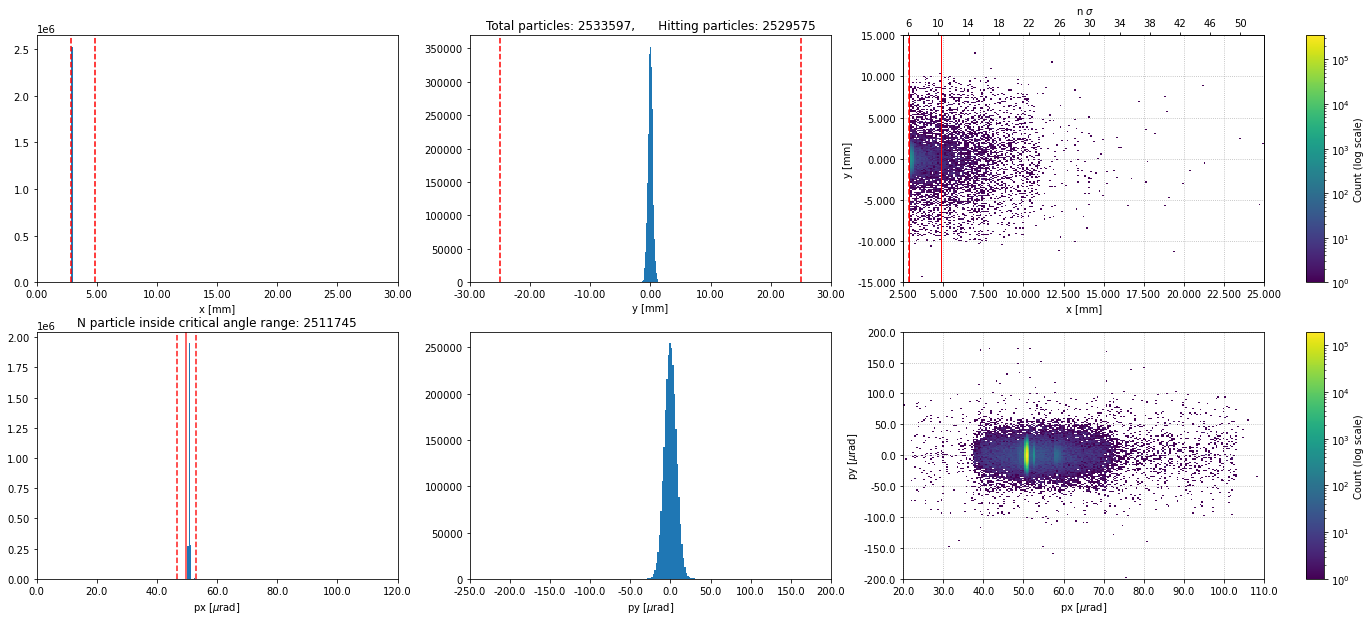

In [94]:
CRY_ls3000.load_particles(lin_scan3000, 'CRY_impacts',  get_absorbed='all')
CRY_ls3000.compute_impact_particles(xpcrit = True)

In [95]:
CRY_ls3000.count_interactions()

interactions
['CH']                                                         1944828
['MCS', 'VR', 'MCS']                                            465258
['CH', 'DCH', 'MCS']                                             54464
['CH', 'DCH', 'MCS', 'VR', 'MCS']                                52125
['MCS']                                                           5221
nan                                                               3935
['MCS', 'VR', 'MCS', 'A']                                         3834
['MCS', 'VR', 'MCS', 'PN', 'MCS']                                 1263
['MCS', 'VC', 'CH']                                                599
['MCS', 'VR', 'MCS', 'PP', 'MCS']                                  322
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A']                             258
['CH', 'DCH', 'MCS', 'A']                                          247
['MCS', 'VR', 'MCS', 'SD', 'MCS']                                  246
['MCS', 'VR', 'MCS', 'PN', 'MCS', 'VR', 'MCS']                  

In [96]:
CRY_ls3000.channeling_efficiency_sim()

Channeling efficiency: 0.774


In [97]:
CRY_ls3000.CRY_sim_chann_eff    

0.7745008549662245

There are repeated particle ids!


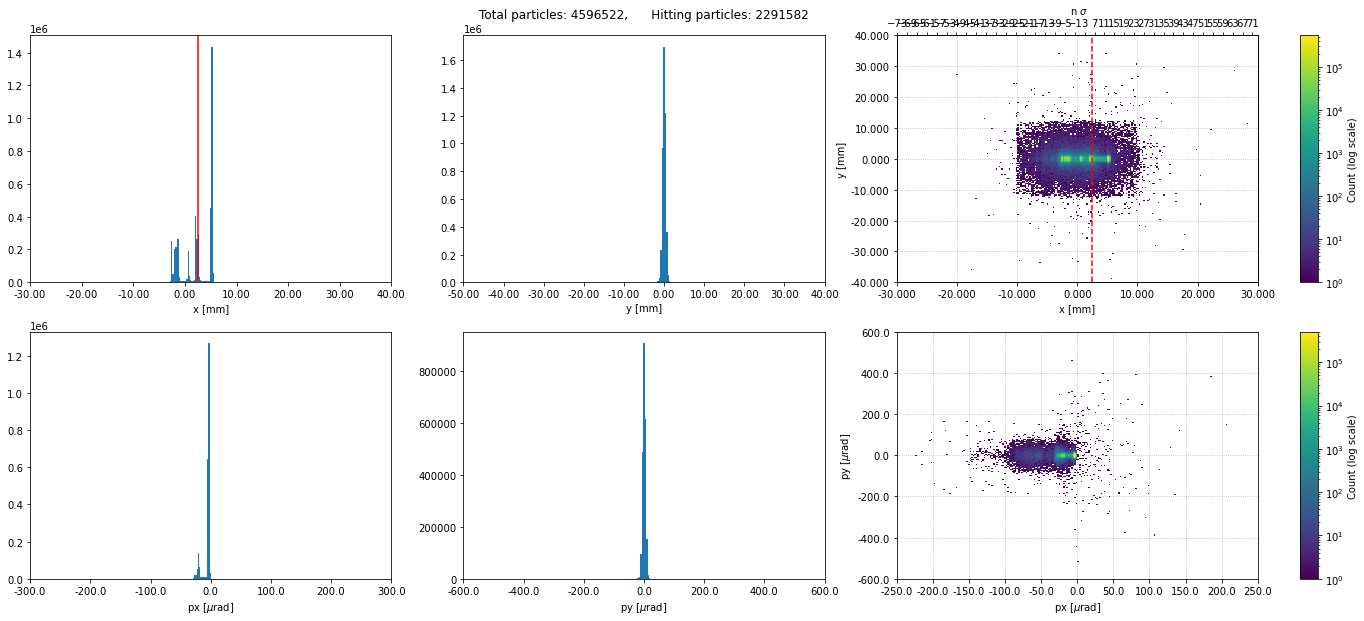

In [30]:
ABS_ls3000.load_particles(lin_scan3000, 'LIN_SCAN_impacts')
ABS_ls3000.compute_impact_particles()

Computing twiss parameters for MD


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


,name,s,x,y,betx,bety,alfx,alfy,mux,muy,s1,sigma_x,sigma_y
26195,tcp.d6r7.b2,6459.742797,-5.580710e-07,-1.646559e-07,148.258770,71.509466,1.906598,-0.960417,15.704216,15.389064,20199.140373,0.000403,0.000280
26952,tcpch.a5r7.b2,6568.727295,5.194824e-07,-2.146849e-07,202.142868,135.005797,-3.542768,2.365477,16.003235,15.490893,20090.155876,0.000470,0.000384
27463,tcsg.b4r7.b2,6653.720795,5.529647e-07,-4.719705e-09,151.988251,121.285772,1.521297,-1.169958,16.056089,15.674012,20005.162376,0.000408,0.000364


Height:  0.8286662224942495  a.u.
Mean:  0.005175003509387147  mm
Sigma:  9.421127749586289e-05  mm
Calculated theta [urad]:  49.59
Efficiency:  82.87 %


(0.001, 0.009)

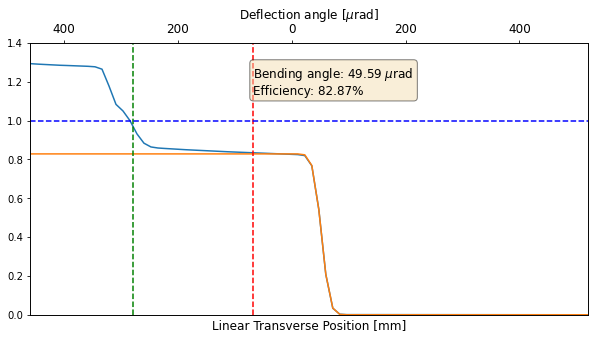

In [31]:
ax = ABS_ls3000.linear_scan(PosEnvelope=None, PosMaxErfFit= 4.2e-3, param0=[0.5, -1, 4.2e-3, 0.0002], CRY_name = CRY_name, COLL_name = LIN_name, config_file = './config_sim.yaml', return_fig=True, MD= 3000, save_data = True)
ax[1].set_xlim(0.001, 0.009)

Check total:  True
Check ch not xp:  False
Check ch xp:  False
Check absorbed:  True
Number of particles channelled but lost before TCLA:  0
Number of particles in xp_crit but lost before TCLA:  4363
Among which absorbed:  4354
Absorbed outside xp_crit:  4504
Check single pass channeling efficiency:  0.7742895875178412 0.7745008549662245


/tmp/cmaccani/ipykernel_22337/1878091588.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  new_A = A/funct_area*hist_area
/tmp/cmaccani/ipykernel_22337/1878091588.py:92: RuntimeWarning: invalid value encountered in double_scalars
  new_A = A/funct_area*hist_area


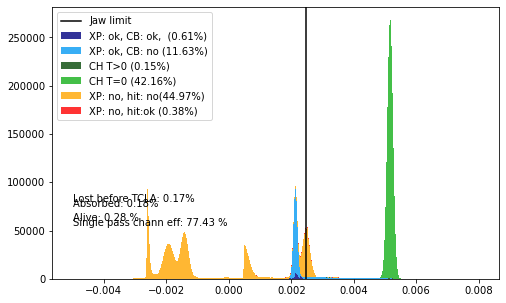

In [100]:
plot_y(CRY_ls3000, ABS_ls3000)

## 5000 GeV

In [9]:
CRY_ls5000 = CrystalAnalysis(plane='H', n_sigma=6.059729, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0143626991, miscut = -0.014324,sigma=0.00036437546194610925, jaw_L=0.0022085360957426565)
ABS_ls5000 = TargetAnalysis(plane='H', n_sigma=6.059729, target_type='collimator', length=1,sigma=0.0003175488547165325, jaw_L=0.0019248150622495075)

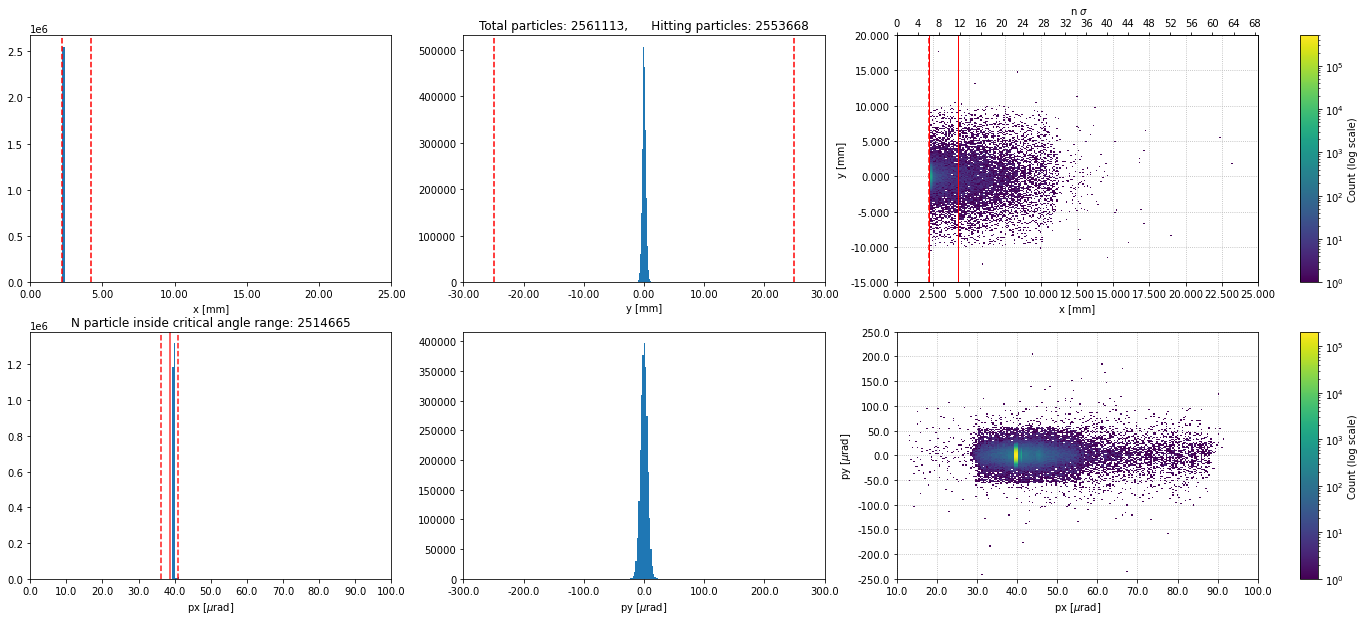

In [10]:
CRY_ls5000.load_particles(lin_scan5000, 'CRY_impacts',  get_absorbed='all')
CRY_ls5000.compute_impact_particles(xpcrit = True)

In [11]:
CRY_ls5000.channeling_efficiency_sim()


Channeling efficiency: 0.694


In [12]:
CRY_ls5000.CRY_sim_chann_eff

0.6947505835170005

There are repeated particle ids!


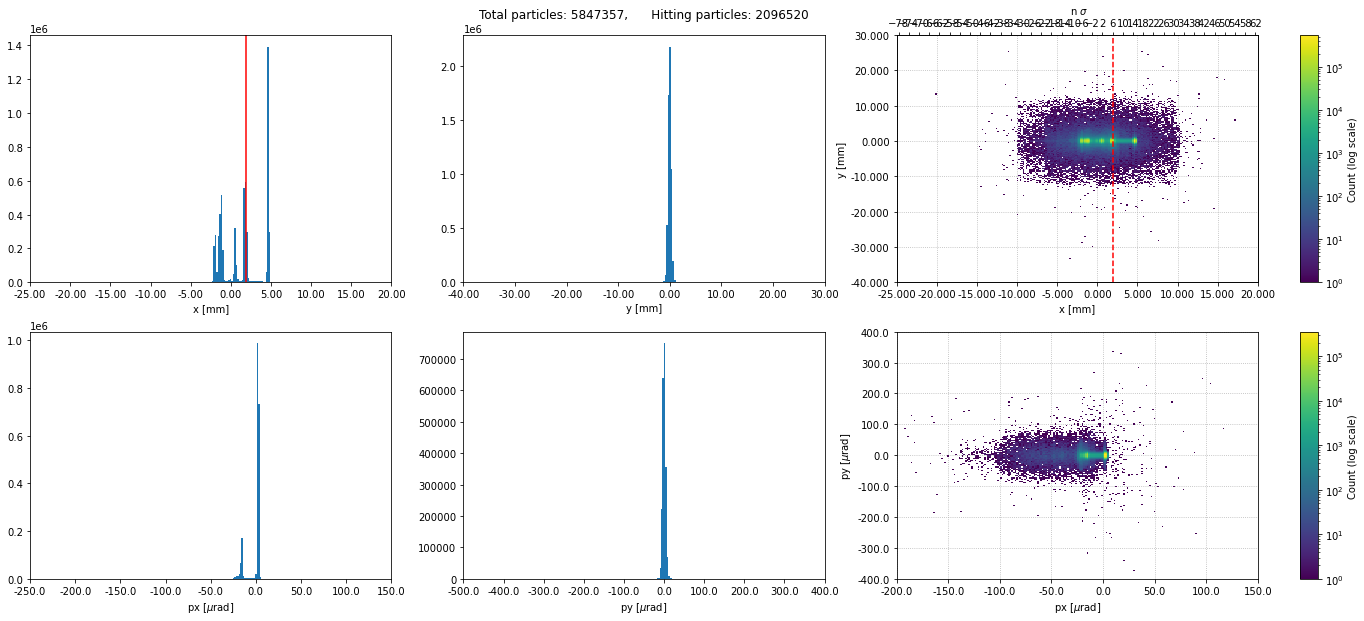

In [10]:
ABS_ls5000.load_particles(lin_scan5000, 'LIN_SCAN_impacts')
ABS_ls5000.compute_impact_particles()

Computing twiss parameters for MD


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


,name,s,x,y,betx,bety,alfx,alfy,mux,muy,s1,sigma_x,sigma_y
26195,tcp.d6r7.b2,6459.742797,-5.579976e-07,-1.645768e-07,148.258768,71.509467,1.906598,-0.960417,15.704216,15.389064,20199.140373,0.000312,0.000217
26952,tcpch.a5r7.b2,6568.727295,5.194388e-07,-2.145942e-07,202.142868,135.005796,-3.542768,2.365477,16.003235,15.490893,20090.155876,0.000364,0.000298
27463,tcsg.b4r7.b2,6653.720795,5.529109e-07,-4.736548e-09,151.988250,121.285771,1.521297,-1.169958,16.056089,15.674012,20005.162376,0.000316,0.000282


Height:  0.8115865913268562  a.u.
Mean:  0.004654539715295892  mm
Sigma:  6.780073026049329e-05  mm
Calculated theta [urad]:  49.598
Efficiency:  81.16 %


(0.001, 0.007)

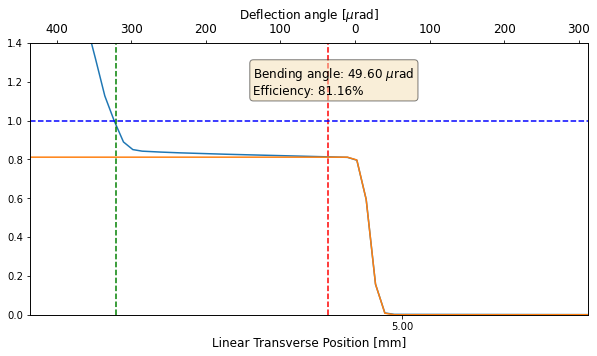

In [11]:
ax  = ABS_ls5000.linear_scan(PosEnvelope=None, PosMaxErfFit= 4.2e-3, param0=[0.5, -1, 4.2e-3, 0.0002], CRY_name = CRY_name, COLL_name = LIN_name, config_file = './config_sim.yaml', return_fig=True, MD= 5000, save_data=True)
ax[1].set_xlim(0.001, 0.007)

Check total:  True
Check ch not xp:  False
Check ch xp:  False
Check absorbed:  True
Number of particles channelled but lost before TCLA:  2
Number of particles in xp_crit but lost before TCLA:  6182
Among which absorbed:  6182
Absorbed outside xp_crit:  6478
Check single pass channeling efficiency:  0.6943533234049069 0.6947505835170005


/tmp/cmaccani/ipykernel_39286/1878091588.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  new_A = A/funct_area*hist_area
/tmp/cmaccani/ipykernel_39286/1878091588.py:92: RuntimeWarning: invalid value encountered in double_scalars
  new_A = A/funct_area*hist_area


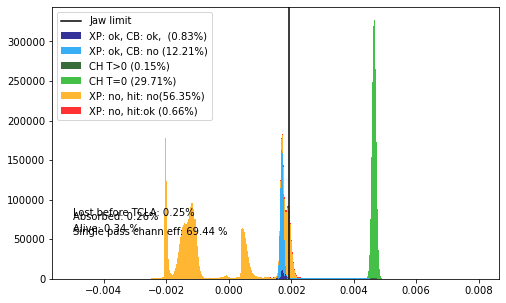

In [17]:
plot_y(CRY_ls5000, ABS_ls5000)

In [ ]:
CRY_ls5000.data[CRY_ls5000.data.at_element!=LIN_name].sort_values('intera')

,zeta,x,px,y,py,delta,this_turn,particle_id,at_element,at_turn,CRY_turn,interactions
19,3.186361e-12,0.002266,0.000040,-0.000061,-9.988374e-07,0.000000,0,19,tcspm.b4r7.b2,0,[0],['CH']
1696853,3.169014e-12,0.002267,0.000040,0.000076,-1.270381e-06,0.000000,0,1656240,tcspm.b4r7.b2,0,[0],['CH']
1696859,3.356697e-12,0.002266,0.000040,-0.000399,8.749428e-06,0.000000,0,1656246,tcspm.b4r7.b2,0,[0],['CH']
1696866,3.366272e-12,0.002266,0.000040,0.000187,-1.002724e-05,0.000000,0,1656253,tcspm.b4r7.b2,0,[0],['CH']
1696874,3.164064e-12,0.002266,0.000040,0.000006,6.138000e-07,0.000000,0,1656260,tcspm.b4r7.b2,0,[0],"['CH', 'DCH', 'MCS']"
...,...,...,...,...,...,...,...,...,...,...,...,...
347154,3.290941e-03,0.002209,0.000038,0.000061,2.637865e-06,-0.000006,150,338807,alive,200,"[0, 7, 150]",['CH']
570007,7.118931e-03,0.002210,0.000038,0.000021,-5.860680e-06,-0.000006,164,556331,alive,200,"[0, 164]",['CH']
1793244,4.670596e-03,0.002210,0.000038,0.000220,1.059511e-06,-0.000008,175,1750358,alive,200,"[0, 7, 175]",['CH']
539222,9.551658e-03,0.002209,0.000038,0.000282,-6.745454e-06,-0.000004,189,526236,alive,200,"[0, 189]",['CH']


# Angular Scan

In [6]:
def load_angular_scan(folder_prefix = '', data_dict = None, folder_list = None, cry_name = 'CRY',  path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/"):
    data_dict = {} if data_dict is None else data_dict
    if folder_list is None:
        folder_list = ls(return_list=True)
        folder_list = [folder for folder in folder_list if folder_prefix in folder]
    for folder in folder_list:
        ang_dict = {}
        ang_key = float(folder.split('__2025')[0].split('_')[-1])
        print(f'Loading {ang_key} , {folder}\n')
        try :
            file_lines = get_simulation_output(folder, print_1=False, path = path).split('\n')
        except:
            print(f'Skipping {ang_key} \n')
            continue
        for i in range(len(file_lines)):
            if 'CrystalAnalysis' in file_lines[i] and cry_name in file_lines[i-1]:
                ang_dict['obj'] = eval(file_lines[i])
                ang_dict['obj'].load_particles(folder)
                ang_dict['CRY_abs'] = ang_dict['obj'].n_CRY_absorbed
                ang_dict['angle'] = ang_dict['obj'].align_angle - ang_dict['obj'].miscut
                ang_dict['align_angle'] = ang_dict['obj'].align_angle
                ang_dict['npart'] = ang_dict['obj'].n_jobs*ang_dict['obj'].part_per_job
        data_dict[ang_key] = ang_dict
        data_dict = dict(sorted(data_dict.items()))

    return data_dict


def save_scan(dict_data, file_name, output_path='./Plots/', df_key='scan'):
    dict_copy = copy.deepcopy(dict_data)
    for key in dict_copy.keys():
        del dict_copy[key]['obj']
    df = pd.DataFrame(dict_copy).T.reset_index()
    df.to_hdf(output_path + file_name, key = df_key, mode='w', format='table', complevel=9, complib='blosc')
        

In [7]:
def plot_angular_scan(data_dict, cry_name = 'CRY', normalize = False):
    fig, ax = plt.subplots(figsize=(10, 5))
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(data_dict[key]['angle'])
        norm_abs.append(data_dict[key][cry_name+'_abs'] / (data_dict[key]['npart'] ))

    if normalize:
        ax.plot(angles, norm_abs, marker='o')
    else:
        ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel('Angle [rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), norm_abs, alpha=0.0, color='k')
    return fig, ax, ax2

In [80]:
ang_scan = load_angular_scan(folder_prefix='MD_1000GeV_ANG_SCAN_', cry_name='CRY')

cat: '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/MD_1000GeV_ANG_SCAN__29.7__20250110-1006/Job.0/htcondor*.out': No such file or directory
cat: '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/MD_1000GeV_ANG_SCAN__26.4__20250110-1006/Job.0/htcondor*.out': No such file or directory


File not found at: /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/MD_1000GeV_ANG_SCAN__29.7__20250110-1006/Job.0/htcondor*.out
Skipping 29.7 

File not found at: /afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/MD_1000GeV_ANG_SCAN__26.4__20250110-1006/Job.0/htcondor*.out
Skipping 26.4 

!!! Succesful Jobs:  161 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/MD_1000GeV_ANG_SCAN__23.1__20250110-1006


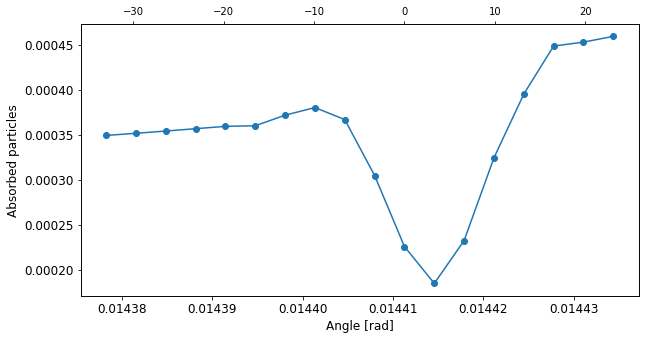

In [85]:
fig, ax, ax2 = plot_angular_scan(ang_scan, normalize=True)

In [8]:
for ang in ang_scan.keys():
    print(ang, ang_scan[ang]['obj'].CRY_sim_chann_eff)
    ang_scan[ang]['obj'].CRY_sim_chann_eff

NameError: name 'ang_scan' is not defined

In [10]:
ang_scan_nt = load_angular_scan(folder_prefix='MD_1000GeV_ANG_SCAN_NOTRANS_HALO', cry_name='CRY')

Loading 30.8 

Loading 28.6 

Loading 26.4 

Loading 24.2 

Loading 22.0 

Loading 19.8 

Loading 17.6 

Loading 15.4 

Loading 13.2 

Loading 11.0 

Loading 8.8 

Loading 6.6 

Loading 4.4 

Loading 2.2 

Loading -0.0 

Loading -2.2 

Loading -4.4 

Loading -6.6 

Loading -8.8 

Loading -11.0 

Loading -13.2 

Loading -15.4 

Loading -17.6 

Loading -19.8 

Loading -22.0 

Loading -24.2 

Loading -26.4 

Loading -28.6 

Loading -30.8 

Loading -33.0 

Loading -35.2 

Loading -37.4 

Loading -39.6 

Loading -41.8 

Loading -44.0 

Loading -46.2 

Loading -48.4 

Loading -50.6 

Loading -52.8 

Loading -55.0 

!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/MD_1000GeV_ANG_SCAN_NOTRANS_HALO__-55.0__20250113-1639
Loading -57.2 

Loading -59.4 

Loading -61.6 

Loading -63.8 

Loading -66.0 

Loading -68.2 

Loading -70.4 

Loading -72.6 

Loading -74.8 

Loading -77.0 

!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim

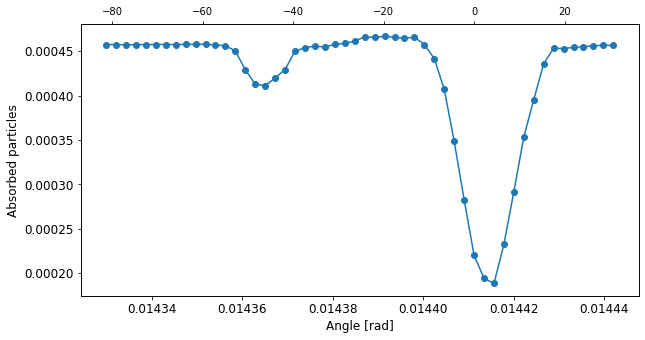

In [11]:
fig, ax, ax2 = plot_angular_scan(ang_scan_nt, normalize=True)

In [12]:
def save_scan(dict_data, file_name, output_path='./Plots/', df_key='scan'):
    dict_copy = copy.deepcopy(dict_data)
    for key in dict_copy.keys():
        del dict_copy[key]['obj']
    df = pd.DataFrame(dict_copy).T.reset_index()
    df.to_hdf(output_path + file_name, key = df_key, mode='w', format='table', complevel=9, complib='blosc')

In [13]:
save_scan(ang_scan_nt, 'CRY_ang_scan_1TeV_NT.h5', df_key='CRY_scan')

In [16]:
ang_scan = load_angular_scan(folder_prefix='MD_1000GeV_ANG_SCAN_HALO__', cry_name='CRY')

Loading 30.8 , MD_1000GeV_ANG_SCAN_HALO__30.8__20250115-0815

Loading 28.6 , MD_1000GeV_ANG_SCAN_HALO__28.6__20250115-0815

Loading 26.4 , MD_1000GeV_ANG_SCAN_HALO__26.4__20250115-0815

Loading 24.2 , MD_1000GeV_ANG_SCAN_HALO__24.2__20250115-0815

Loading 22.0 , MD_1000GeV_ANG_SCAN_HALO__22.0__20250115-0815

Loading 19.8 , MD_1000GeV_ANG_SCAN_HALO__19.8__20250115-0815

Loading 17.6 , MD_1000GeV_ANG_SCAN_HALO__17.6__20250115-0815

Loading 15.4 , MD_1000GeV_ANG_SCAN_HALO__15.4__20250115-0815

Loading 13.2 , MD_1000GeV_ANG_SCAN_HALO__13.2__20250115-0815

Loading 11.0 , MD_1000GeV_ANG_SCAN_HALO__11.0__20250115-0815

Loading 8.8 , MD_1000GeV_ANG_SCAN_HALO__8.8__20250115-0814

Loading 6.6 , MD_1000GeV_ANG_SCAN_HALO__6.6__20250115-0814

Loading 4.4 , MD_1000GeV_ANG_SCAN_HALO__4.4__20250115-0814

Loading 2.2 , MD_1000GeV_ANG_SCAN_HALO__2.2__20250115-0814

Loading -0.0 , MD_1000GeV_ANG_SCAN_HALO__-0.0__20250115-0814

Loading -2.2 , MD_1000GeV_ANG_SCAN_HALO__-2.2__20250115-0814

Loading -4.4 , M

cat: '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/MD_1000GeV_ANG_SCAN_HALO__-24.2__20250114-1824/Job.0/htcondor*.out': No such file or directory


Loading -28.6 , MD_1000GeV_ANG_SCAN_HALO__-28.6__20250114-1824

Loading -30.8 , MD_1000GeV_ANG_SCAN_HALO__-30.8__20250114-1824

Loading -33.0 , MD_1000GeV_ANG_SCAN_HALO__-33.0__20250114-1824

Loading -35.2 , MD_1000GeV_ANG_SCAN_HALO__-35.2__20250114-1824

Loading -37.4 , MD_1000GeV_ANG_SCAN_HALO__-37.4__20250114-1824

Loading -39.6 , MD_1000GeV_ANG_SCAN_HALO__-39.6__20250114-1824

Loading -41.8 , MD_1000GeV_ANG_SCAN_HALO__-41.8__20250114-1824

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/MD_1000GeV_ANG_SCAN_HALO__-41.8__20250114-1824
Loading -44.0 , MD_1000GeV_ANG_SCAN_HALO__-44.0__20250114-1823

Loading -46.2 , MD_1000GeV_ANG_SCAN_HALO__-46.2__20250114-1823

Loading -48.4 , MD_1000GeV_ANG_SCAN_HALO__-48.4__20250114-1823

!!! Succesful Jobs:  97 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/MD_1000GeV_ANG_SCAN_HALO__-48.4__20250114-1823
Loading -50.6 , MD_1000GeV_ANG_SCAN_HALO__-50.6__20250114-1823

!!! Succesful 

cat: '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/MD_1000GeV_ANG_SCAN_HALO__-81.4__20250114-1821/Job.0/htcondor*.out': No such file or directory


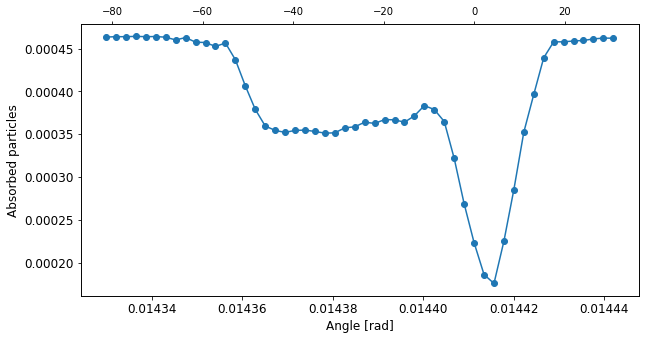

In [17]:
fig, ax, ax2 = plot_angular_scan(ang_scan, normalize=True)

In [20]:
save_scan(ang_scan, 'CRY_ang_scan_1TeV.h5', df_key='CRY_scan')

In [21]:
def scale_x_ticks(x, pos):
    return f"{x * 1e6:.0f}"
    
def plot_angular_scan(data_dict, cry_name = 'TCCS', normalize = False, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(data_dict[key]['angle'])
        norm_abs.append(data_dict[key][cry_name+'_abs'] / (data_dict[key]['npart'] ))

    if normalize:
        ax.plot(angles, norm_abs, marker='o')
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{y_tick*1e3:.{2}f}" for y_tick in ax.get_yticks()])
    else:
        ax.plot(angles, n_cry_abs, marker='o')
    #ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{0}f}" for x_tick in ax.get_xticks()])
    ax.set_xlabel(r'Angle [$\mu$rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles [%]', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), norm_abs, alpha=0.0, color='k')

    ax.xaxis.set_major_formatter(FuncFormatter(scale_x_ticks))
    #ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{0}f}" for x_tick in ax.get_xticks()])
    return fig, ax, ax2

In [15]:
ang_scanv6 = load_angular_scan(folder_prefix='MD_1000GeV_ANG_SCAN_v06', cry_name='CRY')

Loading -26.4 , MD_1000GeV_ANG_SCAN_v06__-26.4__20250415-1732

Loading -28.6 , MD_1000GeV_ANG_SCAN_v06__-28.6__20250415-1732

Loading -30.8 , MD_1000GeV_ANG_SCAN_v06__-30.8__20250415-1732

Loading -33.0 , MD_1000GeV_ANG_SCAN_v06__-33.0__20250415-1732

Loading -35.2 , MD_1000GeV_ANG_SCAN_v06__-35.2__20250415-1732

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/MD_1000GeV_ANG_SCAN_v06__-35.2__20250415-1732
Loading -37.4 , MD_1000GeV_ANG_SCAN_v06__-37.4__20250415-1732

Loading -39.6 , MD_1000GeV_ANG_SCAN_v06__-39.6__20250415-1732

Loading -41.8 , MD_1000GeV_ANG_SCAN_v06__-41.8__20250415-1732

Loading -44.0 , MD_1000GeV_ANG_SCAN_v06__-44.0__20250415-1732

Loading -46.2 , MD_1000GeV_ANG_SCAN_v06__-46.2__20250415-1732

Loading -48.4 , MD_1000GeV_ANG_SCAN_v06__-48.4__20250415-1732

Loading -50.6 , MD_1000GeV_ANG_SCAN_v06__-50.6__20250415-1731

Loading -52.8 , MD_1000GeV_ANG_SCAN_v06__-52.8__20250415-1731

Loading -55.0 , MD_1000GeV_ANG_SCAN_v06__

In [19]:
save_scan(ang_scanv6, 'CRY_ang_scan_1TeV_v6.h5', df_key='CRY_scan')

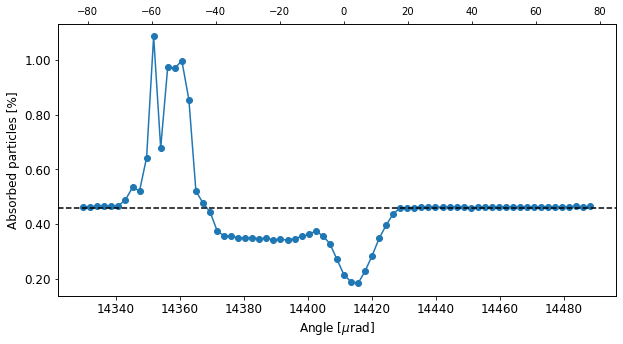

In [31]:
fig, ax, ax2 = plot_angular_scan(ang_scanv6, normalize=True, cry_name = 'CRY')
ax.axhline(0.00046, color='k', linestyle='--', label='20%') 

In [29]:
ang_scanv6.keys()

dict_keys([-81.4, -79.2, -77.0, -74.8, -72.6, -70.4, -68.2, -66.0, -63.8, -61.6, -59.4, -57.2, -55.0, -52.8, -50.6, -48.4, -46.2, -44.0, -41.8, -39.6, -37.4, -35.2, -33.0, -30.8, -28.6, -26.4, -24.2, -22.0, -19.8, -17.6, -15.4, -13.2, -11.0, -8.8, -6.6, -4.4, -2.2, -0.0, 2.2, 4.4, 6.6, 8.8, 11.0, 13.2, 15.4, 17.6, 19.8, 22.0, 24.2, 26.4, 28.6, 30.8, 33.0, 35.2, 37.4, 39.6, 41.8, 44.0, 46.2, 48.4, 50.6, 52.8, 55.0, 57.2, 59.4, 61.6, 63.8, 66.0, 68.2, 70.4, 72.6, 74.8, 77.0])

## TABLE

In [7]:
lin_scan100 = 'MD_1000GeV_LIN_SCAN_full_20241206-1457'
lin_scan450 = 'MD_1000GeV_LIN_SCAN_full_450_20241209-1810'
lin_scan3000 = 'MD_1000GeV_LIN_SCAN_full_3000_20241209-1811'
lin_scan5000 = 'MD_1000GeV_LIN_SCAN_full_5000_20241209-1811'

In [8]:
CRY_ls450 = CrystalAnalysis(plane='H', n_sigma=6.03665, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0144525418, miscut = -0.014324,sigma=0.001214925952193352, jaw_L=0.007334604717154749)

In [9]:
CRY_ls1000 = CrystalAnalysis(plane='H', n_sigma=6.110539, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0144112698, miscut = -0.014324,sigma=0.0008148661018450332, jaw_L=0.00497979123700652)

In [10]:
CRY_ls3000 = CrystalAnalysis(plane='H', n_sigma=6.037554, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0143737785, miscut = -0.014324,sigma=0.0004704161014142652, jaw_L=0.0028406819801725307)

In [11]:
CRY_ls5000 = CrystalAnalysis(plane='H', n_sigma=6.059729, length=0.004, ydim=0.05, xdim=0.002,bending_radius=80.0, align_angle=0.0143626991, miscut = -0.014324,sigma=0.00036437546194610925, jaw_L=0.0022085360957426565)

In [ ]:
CRY_ls450.load_particles(lin_scan450, 'CRY_impacts', n_return= 1)

In [13]:
CRY_ls450.xp_crit

9.11892727083999e-06

In [27]:
CRY_ls450.emittance

7.302502295894673e-09

In [20]:
CRY_ls450.twiss_MD( MD=450, config_file = './config_sim.yaml', line_file= './line_sim.yaml')

Computing twiss parameters for MD


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


,name,s,x,y,betx,bety,alfx,alfy,mux,muy,s1,sigma_x,sigma_y
26195,tcp.d6r7.b2,6459.742797,-5.631265e-07,-1.700940e-07,148.258908,71.509408,1.906600,-0.960417,15.704216,15.389064,20199.140373,0.001041,0.000723
26952,tcpch.a5r7.b2,6568.727295,5.224859e-07,-2.209266e-07,202.142840,135.005839,-3.542768,2.365477,16.003235,15.490893,20090.155876,0.001215,0.000993
27463,tcsg.b4r7.b2,6653.720795,5.566664e-07,-3.560327e-09,151.988322,121.285829,1.521297,-1.169958,16.056089,15.674011,20005.162376,0.001054,0.000941


In [14]:
CRY_ls1000.load_particles(lin_scan100, 'CRY_impacts', n_return= 1)

In [15]:
CRY_ls1000.xp_crit

6.015143690967734e-06

In [26]:
CRY_ls1000.emittance

3.2850693203527123e-09

In [21]:
CRY_ls1000.twiss_MD( MD=1000, config_file = './config_sim.yaml', line_file= './line_sim.yaml')

Computing twiss parameters for MD


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


,name,s,x,y,betx,bety,alfx,alfy,mux,muy,s1,sigma_x,sigma_y
26195,tcp.d6r7.b2,6459.742797,-5.589921e-07,-1.656466e-07,148.258795,71.509456,1.906598,-0.960417,15.704216,15.389064,20199.140373,0.000698,0.000485
26952,tcpch.a5r7.b2,6568.727295,5.200296e-07,-2.158221e-07,202.142863,135.005804,-3.542768,2.365477,16.003235,15.490893,20090.155876,0.000815,0.000666
27463,tcsg.b4r7.b2,6653.720795,5.536391e-07,-4.508481e-09,151.988264,121.285782,1.521297,-1.169958,16.056089,15.674011,20005.162376,0.000707,0.000631


In [16]:
CRY_ls3000.load_particles(lin_scan3000, 'CRY_impacts', n_return= 1)

In [17]:
CRY_ls3000.xp_crit

3.260392118053477e-06

In [25]:
CRY_ls3000.emittance

1.094804013571951e-09

In [22]:
CRY_ls3000.twiss_MD( MD=3000, config_file = './config_sim.yaml', line_file= './line_sim.yaml')

Computing twiss parameters for MD


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


,name,s,x,y,betx,bety,alfx,alfy,mux,muy,s1,sigma_x,sigma_y
26195,tcp.d6r7.b2,6459.742797,-5.580710e-07,-1.646559e-07,148.258770,71.509466,1.906598,-0.960417,15.704216,15.389064,20199.140373,0.000403,0.000280
26952,tcpch.a5r7.b2,6568.727295,5.194824e-07,-2.146849e-07,202.142868,135.005797,-3.542768,2.365477,16.003235,15.490893,20090.155876,0.000470,0.000384
27463,tcsg.b4r7.b2,6653.720795,5.529647e-07,-4.719705e-09,151.988251,121.285772,1.521297,-1.169958,16.056089,15.674012,20005.162376,0.000408,0.000364


In [18]:
CRY_ls5000.load_particles(lin_scan5000, 'CRY_impacts', n_return= 1)

In [19]:
CRY_ls5000.xp_crit

2.3611456570659894e-06

In [28]:
dp = 1.92e-10 
pot_crit = 21.34
eta = 0.9

def calculate_Rc(pc, bending_radius = 10 ):
    return  pc/(2*np.sqrt(eta)*pot_crit) * (dp/2)

def calculate_xpcrit(pc, bending_radius = 10.00):   
    Rcrit = calculate_Rc(pc, bending_radius)
    xp_crit = np.sqrt(2*eta*pot_crit/pc)*(1 - Rcrit/bending_radius)
    return xp_crit

In [30]:
calculate_xpcrit(5000e9, 80.00)

2.3609865240568636e-06

In [24]:
CRY_ls5000.emittance

6.56856147327076e-10

In [23]:
CRY_ls5000.twiss_MD( MD=5000, config_file = './config_sim.yaml', line_file= './line_sim.yaml')

Computing twiss parameters for MD


Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


,name,s,x,y,betx,bety,alfx,alfy,mux,muy,s1,sigma_x,sigma_y
26195,tcp.d6r7.b2,6459.742797,-5.579976e-07,-1.645768e-07,148.258768,71.509467,1.906598,-0.960417,15.704216,15.389064,20199.140373,0.000312,0.000217
26952,tcpch.a5r7.b2,6568.727295,5.194388e-07,-2.145942e-07,202.142868,135.005796,-3.542768,2.365477,16.003235,15.490893,20090.155876,0.000364,0.000298
27463,tcsg.b4r7.b2,6653.720795,5.529109e-07,-4.736548e-09,151.988250,121.285771,1.521297,-1.169958,16.056089,15.674012,20005.162376,0.000316,0.000282
